In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pyhepmc
import itertools
import math
import uproot 


# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 12, 6
mpl.rcParams['figure.dpi'] = 200

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

def fix_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    return ax

In [10]:
#Useful constants
tm15fm2_to_nb = 1.e-8
tm38cm2_to_nb = 1.
GeVm2_to_nb = 389379.09

#GENIE total cross section
noah_xsec =  16627.015293083106/(2*np.pi)#4.936716e-05#nb

genie_numevents = 400000
noah_numevents = 100000
achilles_numevents = 400000

In [8]:
#QE prediction from theory code
pred18 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_18p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred18.columns = ['w','sig']

pred25 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_25p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred25.columns = ['w','sig']

pred30 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_30p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred30.columns = ['w','sig']

pred = [pred18,pred25,pred30]



In [31]:
#Get Noah's events

probe_p4 = []
lepton_p4 = []
innuc1_p4 = []
outnuc1_p4 = []
innuc2_p4 = []
outnuc2_p4 = []

with open('test.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4,p5,p6 in itertools.zip_longest(*[file]*6):
        #print(p3)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        p5 = [float(x) for x in p5.split()]
        p6 = [float(x) for x in p6.split()]
        probe_p4.append(p1)
        lepton_p4.append(p2)
        innuc1_p4.append(p3)
        outnuc1_p4.append(p4)
        innuc2_p4.append(p5)
        outnuc2_p4.append(p6)
        

In [32]:
def get_double_diff_xsec(probeP4, leptonP4, angles, delta, xsec, events, bins, low_bins, high_bins):
    
    angular_dif = []
    
    double_dif_angles = []
    p1 = []
    p2 = []
    pp1 = []
    pp2 = []
    pp12cos = []
    p12cos = []
    p1cos = []
    p2cos = []
    weights = []
    
    for angle,low_bin,high_bin in zip(angles,low_bins,high_bins):
        double_dif = []
        angular = []

        high_cos = math.cos((angle + delta)*np.pi/180)
        low_cos = math.cos((angle - delta)*np.pi/180)
        delta_cos = (low_cos - high_cos)
        #print(delta_cos)

        for probe,lep,nuc1,nuc2,nucp1,nucp2 in zip(probeP4, leptonP4, innuc1_p4, innuc2_p4,outnuc1_p4,outnuc2_p4):
            omega = probe[0] - lep[0]
            if omega < 0:
                print('negative omega!')
                print(probe[0])
                print(lep[0])
            probe_3 = [probe[1], probe[2], probe[3]]
            lep_3 = [lep[1], lep[2], lep[3]]
            n1 = [nuc1[1],nuc1[2],nuc1[3]]
            n2 = [nuc2[1],nuc2[2],nuc2[3]]
            
            np1 = [nucp1[1],nucp1[2],nucp1[3]]
            np2 = [nucp2[1],nucp2[2],nucp2[3]]
            cos_theta = np.dot(lep_3,probe_3)/(np.sqrt(np.dot(lep_3,lep_3))*np.sqrt(np.dot(probe_3,probe_3)))
            pn1 = np.sqrt(np.dot(n1,n1))
            pn2 = np.sqrt(np.dot(n2,n2))
            ppn1 = np.sqrt(np.dot(np1,np1))
            ppn2 = np.sqrt(np.dot(np2,np2))
            
            z = np.array([0,0,1])
            p1cos.append(np.dot(probe_3,np1)/ppn1/np.sqrt(np.dot(probe_3,probe_3)))
            p2cos.append(np.dot(probe_3,np2)/ppn2/np.sqrt(np.dot(probe_3,probe_3)))
            
            angular.append(cos_theta)
            p1.append(pn1)
            p2.append(pn2)
            pp1.append(ppn1)
            pp2.append(ppn2)
            pp12cos.append(np.dot(np1,np2)/(ppn1*ppn2))
            p12cos.append(np.dot(n1,n2)/(pn1*pn2))
            if cos_theta < low_cos and cos_theta > high_cos:
                #print(cos_theta)
                double_dif.append(omega)

        #bin_width = delta_cos*(high_bin - low_bin)/bins
        bin_width = (high_bin - low_bin)/bins

        double_dif = np.array(double_dif)
        angular = np.array(angular)
        angular_dif.append(angular)
        double_dif_angles.append(double_dif)
        weight = (xsec)/events/bin_width
        weights.append(weight)
    
    return angular_dif,double_dif_angles,p1,p2,pp1,pp2,p12cos,pp12cos,p1cos,p2cos,weights



In [33]:
numbins = 30
omegalows = [200]
omegahighs = [2000]

dtheta = 1
angles = [37.5]

noah_angular,noah_dsig,p1,p2,pp1,pp2,p12cos,pp12cos,p1cos,p2cos,noah_weights = get_double_diff_xsec(probe_p4, lepton_p4, angles, dtheta, noah_xsec, noah_numevents, numbins, omegalows, omegahighs)
 

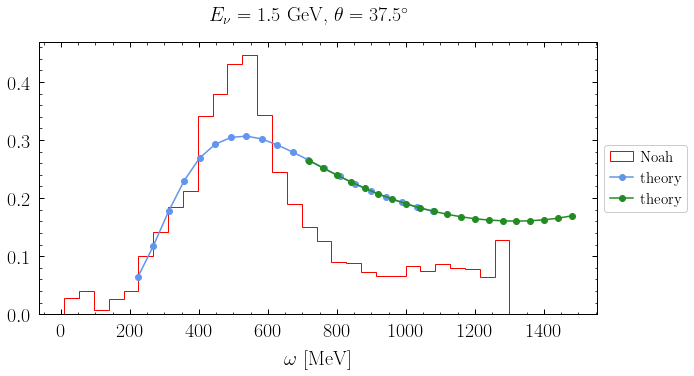

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
theory = np.loadtxt('test2_an2_cm_free.out')

theory2 = np.loadtxt('test3_an2_cm_free.out.out')

theory_w = theory[:, 0]
theory_xsec = theory[:,1]

theory2_w = theory2[:, 0]
theory2_xsec = theory2[:,1]
for i,angle in enumerate(angles):

    #ax[i].plot(pred[i]['w'], pred[i]['sig']*tm15fm2_to_nb, label='Theory', color='black', linestyle='--')

    #ax[i].hist(noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(noah_dsig[i])*noah_weights[i],histtype='step',color='red',label='Noah')
    
    ax.hist(noah_dsig[i],weights=np.ones_like(noah_dsig[i])*noah_weights[i],bins=30,histtype='step',color='red',label='Noah')
    ax.plot(theory_w, theory_xsec/10, marker='o', label='theory')  
    ax.plot(theory2_w, theory2_xsec/10, marker='o', label='theory')


    #ax[i].hist(achilles_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(achilles_dsig[i])*achilles_weights[i],histtype='step',color='blue',label='Achilles')

    #ax[i].hist(genie_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(genie_dsig[i])*genie_weights[i],histtype='step',color='purple',label='GENIE')
      
    #ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax.set_xlabel(r'$\omega$ [MeV]')
#    ax = fix_ax(ax[i])
    
#ax.set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
#ax.set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax.set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax.set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1.5$ GeV, $\theta = 37.5^\circ$',fontsize=20)
plt.show()

In [125]:
1.3/2*np.pi

2.0420352248333655

Text(0, 0.5, 'p2 (MeV)')

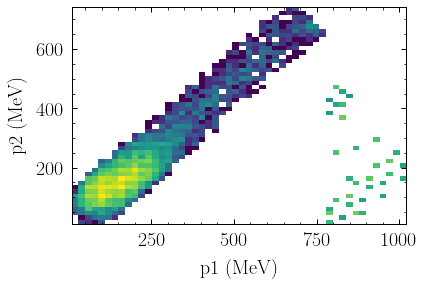

In [36]:
#plt.hist(p1)
#plt.hist(p2)
#len(p1)
plt.hist2d(p1,p2,bins=50,norm=mpl.colors.LogNorm())
plt.xlabel('p1 (MeV)')
plt.ylabel('p2 (MeV)')

(array([[ 0.,  0.,  4., ...,  0.,  0.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 3., 10.,  4., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  8.87971738,  23.56085013,  38.24198287,  52.92311561,
         67.60424836,  82.2853811 ,  96.96651384, 111.64764659,
        126.32877933, 141.00991207, 155.69104482, 170.37217756,
        185.0533103 , 199.73444305, 214.41557579, 229.09670853,
        243.77784128, 258.45897402, 273.14010676, 287.82123951,
        302.50237225, 317.18350499, 331.86463774, 346.54577048,
        361.22690322, 375.90803597, 390.58916871, 405.27030145,
        419.95143419, 434.63256694, 449.31369968, 463.99483242,
        478.67596517, 493.35709791, 508.03823065, 522.7193634 ,
        537.40049614, 552.08162888, 566.76276163, 581.44389437,
        596.12502711, 610.80615986, 625.4872926 , 640.16842534,
        654

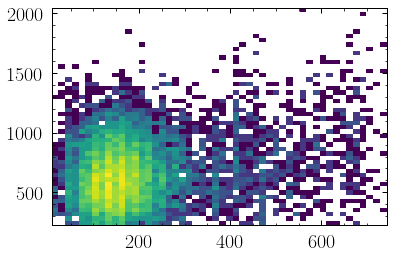

In [37]:
plt.hist2d(p2,pp2,bins=50,norm=mpl.colors.LogNorm())

Text(0, 0.5, 'p2 (MeV)')

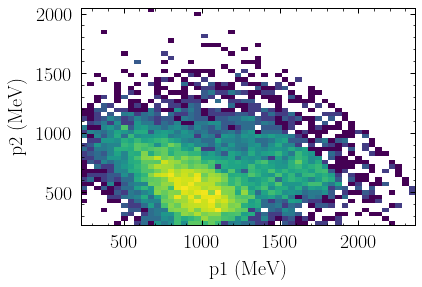

In [38]:

plt.hist2d(pp1,pp2,bins=50,norm=mpl.colors.LogNorm())
plt.xlabel('p1 (MeV)')
plt.ylabel('p2 (MeV)')

#plt.hist(pp1)
#plt.hist(pp2)

Text(0.5, 0, '$cos(\\theta_{p^\\prime_{1}p^\\prime_{2}})$ ')

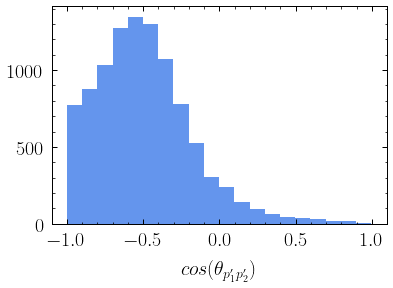

In [39]:
plt.hist(pp12cos,bins=20)
plt.xlabel(r'$cos(\theta_{p^\prime_{1}p^\prime_{2}})$ ')

Text(0.5, 1.0, '$E_{e} = 1.5$ GeV, $\\theta_{e} = 37.5^{\\circ}$')

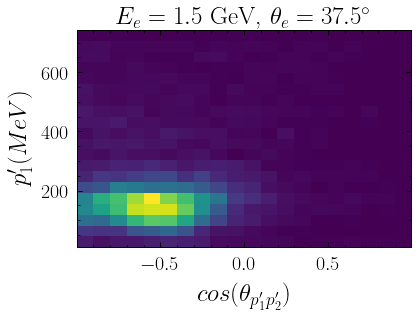

In [40]:
plt.hist2d(pp12cos,p2,bins=20)
plt.xlabel(r'$cos(\theta_{p^\prime_{1}p^\prime_{2}})$ ',fontsize=25)
plt.ylabel(r'$p^{\prime}_{1} (MeV)$ ',fontsize=25)
plt.title(r'$E_{e} = 1.5$ GeV, $\theta_{e} = 37.5^{\circ}$',fontsize=25)

(array([154., 203., 195., 231., 257., 275., 305., 363., 380., 437., 446.,
        435., 454., 457., 403., 410., 344., 349., 293., 226., 221., 176.,
        119., 105., 103.,  79.,  84.,  56.,  51.,  39.,  33.,  28.,  21.,
         25.,  14.,  14.,  14.,  16.,  10.,  17.,  16.,   7.,  10.,   9.,
          7.,   8.,   7.,   4.,   0.,   3.]),
 array([-0.99953546, -0.95960676, -0.91967806, -0.87974935, -0.83982065,
        -0.79989195, -0.75996324, -0.72003454, -0.68010583, -0.64017713,
        -0.60024843, -0.56031972, -0.52039102, -0.48046232, -0.44053361,
        -0.40060491, -0.36067621, -0.3207475 , -0.2808188 , -0.2408901 ,
        -0.20096139, -0.16103269, -0.12110399, -0.08117528, -0.04124658,
        -0.00131788,  0.03861083,  0.07853953,  0.11846823,  0.15839694,
         0.19832564,  0.23825434,  0.27818305,  0.31811175,  0.35804045,
         0.39796916,  0.43789786,  0.47782656,  0.51775527,  0.55768397,
         0.59761267,  0.63754138,  0.67747008,  0.71739878,  0.75732749,
 

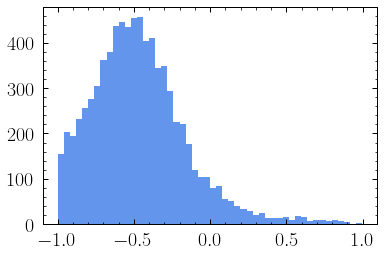

In [41]:
nuc_mom_cut = (np.array(pp1) < 1500) & (np.array(pp2) < 1000)
plt.hist(np.array(pp12cos)[nuc_mom_cut],bins=50)

In [15]:
def get_transverse_proj(vec1,vec2):
    parallel_proj = np.dot(vec1,vec2) / np.linalg.norm(vec2) * (vec2/np.linalg.norm(vec2))
    
    trans_proj = vec1 - parallel_proj
    
    return trans_proj


def get_TKI_xsec(conversion,xsec, events, outnuc4, lep4, probe4, bin_alphaT, bin_PT, low_binalphaT, high_binalphaT, low_binPT, high_binPT):
    
    moms = []
    alphaT = []
    
    for nuc,lep,probe in zip(outnuc4,lep4,probe4):
        
        probe_mom = np.array([probe[1],probe[2],probe[3]])
        
        
        nuc_mom = np.array([nuc[1], nuc[2], nuc[3]])
        nuc_pt = get_transverse_proj(nuc_mom,probe_mom)

        lep_mom = np.array([lep[1], lep[2], lep[3]])
        lep_pt = get_transverse_proj(lep_mom,probe_mom)
        lep_pt_mag = np.linalg.norm(lep_pt)

        pt_mom = lep_pt + nuc_pt

        pt = np.linalg.norm(pt_mom)

        lepdotpt = np.dot(lep_mom,pt_mom)

        moms.append(pt)
        if np.abs(((-lepdotpt) / (lep_pt_mag * pt)) > 1.):
            print('shit')
        alphaT_val = math.acos( (-lepdotpt) / (lep_pt_mag * pt)) * 180./np.pi
        if alphaT_val > 180.:
            alphaT_val -= 180.
        if alphaT_val < 0.:
            alphaT_val += 180.

        alphaT.append(alphaT_val)
        
    TKI = [moms,alphaT]
        
    PTbin_width = (high_binPT - low_binPT)/bin_PT
    alphaTbin_width = (high_binalphaT - low_binalphaT)/bin_alphaT

    mom_weight = conversion*(xsec)/events/PTbin_width
    alphaT_weight = conversion*(xsec)/events/alphaTbin_width

    TKI_weight = [mom_weight, alphaT_weight]

    return TKI, TKI_weight


In [123]:
TKI, TKI_weight = get_TKI_xsec(1.,noah_xsec, noah_numevents, outnuc1_p4,lepton_p4,probe_p4, 40, 40, 0, 180, 0, 1000) 
#Ac_TKI, Ac_TKI_weight = get_TKI_xsec(1.,achilles_xsec, achilles_numevents,Ac_proton_p4,Ac_lepton_p4, Ac_probe_p4, 40, 40, 0, 180, 0, 800) 
#genie_TKI, genie_TKI_weight = get_TKI_xsec(1.,genie_xsec, genie_numevents,genie_proton_p4[0],genie_lepton_p4, genie_probe_p4, 40, 40, 0, 180, 0, 800)  
    

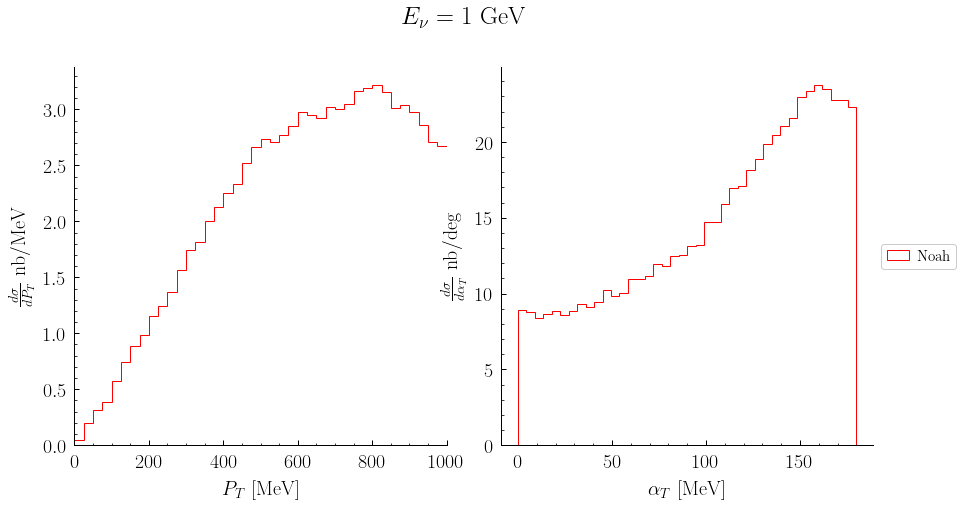

In [124]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(TKI[0], bins = 40, range = (0,1000), weights = np.ones_like(TKI[0])*TKI_weight[0],histtype='step',label='Noah',color='red')

#ax[0].hist(Ac_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ac_TKI[0])*Ac_TKI_weight[0],histtype='step',label='Achilles')

#ax[0].hist(genie_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(genie_TKI[0])*genie_TKI_weight[0],histtype='step',label='Genie',color='purple')
ax[0].set_ylabel(r'$\frac{d\sigma}{dP_{T}}$ $\rm{nb}/\rm{MeV}$')
ax[0].set_xlabel(r'$P_{T}$ [MeV]')
ax[0].set_xlim([0,1000])
#ax[0].set_yscale('log')

ax[0] = fix_ax(ax[0])


ax[1].hist(TKI[1], bins = 40, range = (0,180), weights = np.ones_like(TKI[1])*TKI_weight[1],histtype='step',label='Noah',color='red')
#ax[1].hist(Ac_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ac_TKI[1])*Ac_TKI_weight[1],histtype='step',label='Achilles')
#ax[1].hist(genie_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(genie_TKI[1])*genie_TKI_weight[1],histtype='step',label='Genie',color='purple')
ax[1].set_ylabel(r'$\frac{d\sigma}{d\alpha_{T}}$ $\rm{nb}/\rm{deg}$')
ax[1].set_xlabel(r'$\alpha_{T}$ [MeV]')

ax[1] = fix_ax(ax[1])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV',fontsize=25,y=1.1)
plt.show()


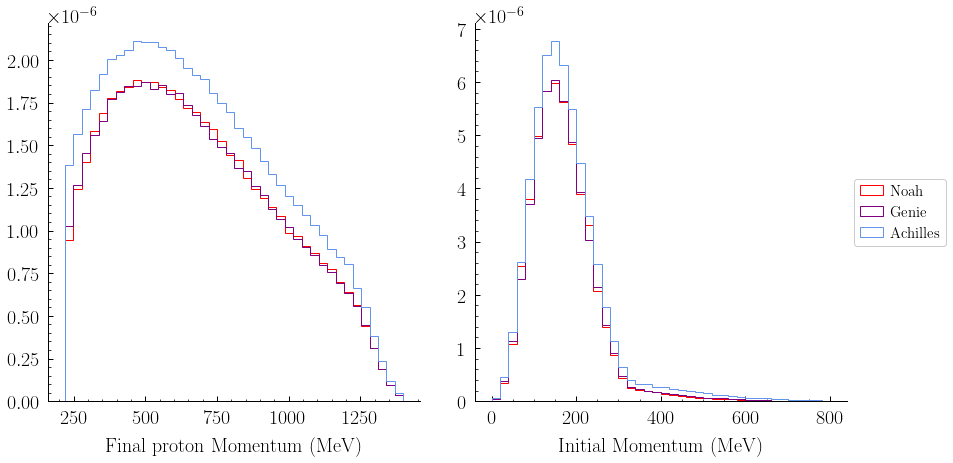

In [7]:
proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in outnuc_p4]
genie_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in genie_proton_p4[0]]
Ac_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ac_proton_p4]

neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in innuc_p4]
genie_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in genie_neutron_p4]
Ac_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ac_neutron_p4]

fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(proton_mom,bins = 40,range=(220,1400),weights = np.ones_like(proton_mom)*noah_xsec/noah_numevents,color='red',histtype='step',label='Noah')
ax[0].hist(genie_proton_mom,bins = 40,range=(220,1400),color='purple',histtype='step',weights = np.ones_like(genie_proton_mom)*genie_xsec/genie_numevents,label='Genie')
ax[0].hist(Ac_proton_mom,bins = 40,range=(220,1400),histtype='step',weights = np.ones_like(Ac_proton_mom)*achilles_xsec/achilles_numevents,label='Achilles')

ax[0] = fix_ax(ax[0])
#ax[0].set_yscale('log')

ax[1].hist(neutron_mom,bins = 40,range=(0,800),weights = np.ones_like(neutron_mom)*noah_xsec/noah_numevents,color='red',histtype='step',label='Noah')
ax[1].hist(genie_neutron_mom,bins = 40,range=(0,800),color='purple',histtype='step',weights = np.ones_like(genie_neutron_mom)*genie_xsec/genie_numevents,label='Genie')
ax[1].hist(Ac_neutron_mom,bins = 40,range=(0,800),histtype='step',weights = np.ones_like(Ac_neutron_mom)*achilles_xsec/achilles_numevents,label='Achilles')

ax[1] = fix_ax(ax[1])
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8,8e-6])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

ax[0].set_xlabel('Final proton Momentum (MeV)')
ax[1].set_xlabel('Initial Momentum (MeV)')
plt.show()



Noahs mean =  -14.267701593893241
Achilles mean =  -17.64681489372548
GENIE mean =  -15.704810453095687


Text(67.3043737352117, 0.5, '$\\frac{d\\sigma}{dP_{N_{L}}}$ [nb/MeV]')

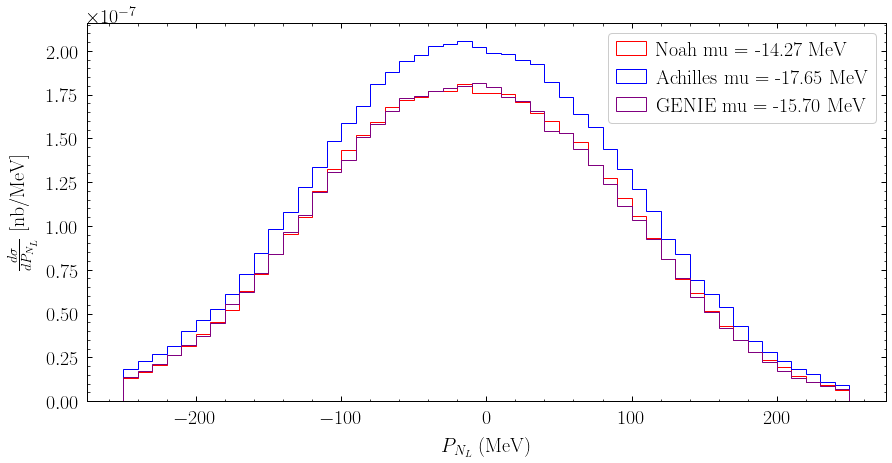

In [70]:
#Look at longitudinal nucleon momentum
#interesting we observe the same shift as https://arxiv.org/pdf/2310.15633.pdf
fig,ax = plt.subplots(1,1,figsize=(12,6))
fig.tight_layout()

from scipy.stats import norm

noah_long = parallel_mom(probe_p4,innuc_p4)
Ac_long = parallel_mom(Ac_probe_p4,Ac_neutron_p4)
genie_long = parallel_mom(genie_probe_p4,genie_neutron_p4)

noah_mean,noah_std=norm.fit(noah_long)
print('Noahs mean = ',noah_mean)
achilles_mean,noah_std=norm.fit(Ac_long)
print('Achilles mean = ',achilles_mean)
genie_mean,noah_std=norm.fit(genie_long)
print('GENIE mean = ',genie_mean)

ax.hist(noah_long, bins = 50, range = (-250,250), weights = np.ones_like(noah_long)*noah_xsec/noah_numevents/10.,histtype='step',label='Noah mu = {:.2f} MeV'.format(noah_mean),color='red')

ax.hist(Ac_long, bins = 50, range = (-250,250), weights = np.ones_like(Ac_long)*achilles_xsec/achilles_numevents/10.,histtype='step',label='Achilles mu = {:.2f} MeV'.format(achilles_mean),color='blue')

ax.hist(genie_long, bins = 50, range = (-250,250), weights = np.ones_like(genie_long)*genie_xsec/genie_numevents/10.,histtype='step',label='GENIE mu = {:.2f} MeV'.format(genie_mean),color='purple')

ax.legend()

ax.set_xlabel(r'$P_{N_{L}}$ (MeV)')
ax.set_ylabel(r'$\frac{d\sigma}{dP_{N_{L}}}$ [nb/MeV]')



In [33]:
def parallel_mom(probe_mom,nuc_mom):
    longmom = []
    
    for probe,nuc in zip(probe_mom, nuc_mom):
        longmom.append( np.dot( probe[1:4],nuc[1:4] )/np.sqrt( np.dot( probe[1:4],probe[1:4] ) ) )
        
    return longmom

In [62]:
#Now lets do comparison for Argon
Ar_probe_p4 = []
Ar_lepton_p4 = []
Ar_innuc_p4 = []
Ar_outnuc_p4 = []

with open('Ar40_CC_1000.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        Ar_probe_p4.append(p1)
        Ar_lepton_p4.append(p2)
        Ar_innuc_p4.append(p3)
        Ar_outnuc_p4.append(p4)

#total cross section
Ar_noah_xsec = 18.06e-05 #nb
Ar_noah_numevents = 400074          
        

In [39]:
#Get GENIE events

Ar_genie_file = uproot.open("/Users/noah/Desktop/numu_Ar40_1GeV.gst.root")
Ar_gst = Ar_genie_file["gst"]
Ar_branches = Ar_gst.arrays()
Ar_genie_probe_p4 = np.transpose([Ar_branches['Ev'],Ar_branches['pxv'], Ar_branches['pyv'], Ar_branches['pzv']])*1.e3
Ar_genie_lepton_p4 = np.transpose([Ar_branches['El'],Ar_branches['pxl'], Ar_branches['pyl'], Ar_branches['pzl']])*1.e3
Ar_genie_neutron_p4 = np.transpose([Ar_branches['En'],Ar_branches['pxn'], Ar_branches['pyn'], Ar_branches['pzn']])*1.e3
Ar_genie_proton_p4 = np.transpose([Ar_branches['Ei'][Ar_branches['pdgi'] == 2212],Ar_branches['pxi'][Ar_branches['pdgi'] == 2212], Ar_branches['pyi'][Ar_branches['pdgi'] == 2212], Ar_branches['pzi'][Ar_branches['pdgi'] == 2212]])*1.e3

#total cross section
Ar_genie_xsec = 18.1068e-05 #nb
Ar_genie_numevents = 400000  


In [63]:
numbins = 25
omegalows = [30,30,30]
omegahighs = [200,250,350]

dtheta = 2.0
angles = [18,25,30]

Ar_noah_dsig,Ar_noah_weights = get_double_diff_xsec(Ar_probe_p4, Ar_lepton_p4, angles, dtheta, Ar_noah_xsec, Ar_noah_numevents, numbins, omegalows, omegahighs)


Ar_genie_dsig,Ar_genie_weights = get_double_diff_xsec(Ar_genie_probe_p4, Ar_genie_lepton_p4, angles, dtheta, Ar_genie_xsec, Ar_genie_numevents, numbins, omegalows, omegahighs)    

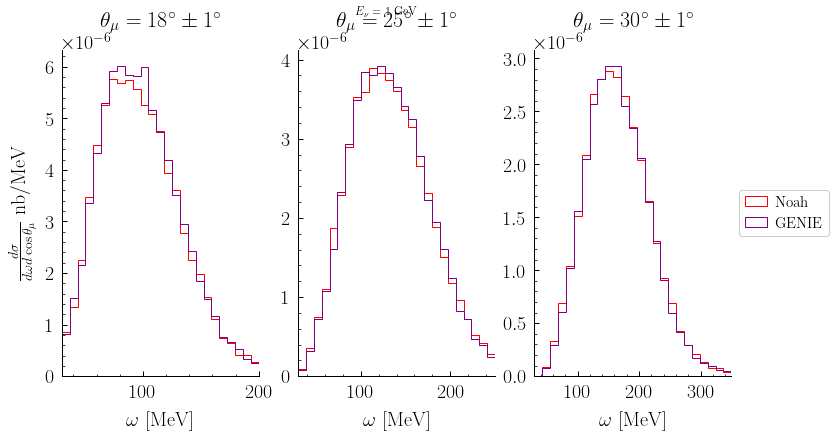

In [64]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i,angle in enumerate(angles):

    ax[i].hist(Ar_noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(Ar_noah_dsig[i])*Ar_noah_weights[i],histtype='step',color='red',label='Noah')

    ax[i].hist(Ar_genie_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(Ar_genie_dsig[i])*Ar_genie_weights[i],histtype='step',color='purple',label='GENIE')
      
    ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax[i].set_xlabel(r'$\omega$ [MeV]')
    ax[i] = fix_ax(ax[i])
    
ax[0].set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

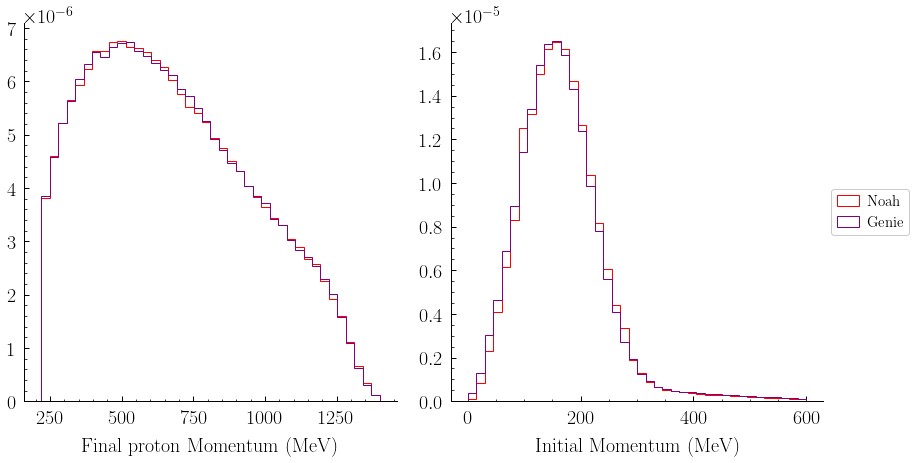

In [66]:
Ar_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_outnuc_p4]
Ar_genie_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_genie_proton_p4[0]]

Ar_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_innuc_p4]
Ar_genie_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_genie_neutron_p4]

fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(Ar_proton_mom,bins = 40,range=(220,1400),weights = np.ones_like(Ar_proton_mom)*Ar_noah_xsec/Ar_noah_numevents,color='red',histtype='step',label='Noah')
ax[0].hist(Ar_genie_proton_mom,bins = 40,range=(220,1400),color='purple',histtype='step',weights = np.ones_like(Ar_genie_proton_mom)*Ar_genie_xsec/Ar_genie_numevents,label='Genie')

ax[0] = fix_ax(ax[0])

ax[1].hist(Ar_neutron_mom,bins = 40,range=(0,600),weights = np.ones_like(Ar_neutron_mom)*Ar_noah_xsec/Ar_noah_numevents,color='red',histtype='step',label='Noah')
ax[1].hist(Ar_genie_neutron_mom,bins = 40,range=(0,600),color='purple',histtype='step',weights = np.ones_like(Ar_genie_neutron_mom)*Ar_genie_xsec/Ar_genie_numevents,label='Genie')

ax[1] = fix_ax(ax[1])
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-7,2.5e-5])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

ax[0].set_xlabel('Final proton Momentum (MeV)')
ax[1].set_xlabel('Initial Momentum (MeV)')
plt.show()

In [68]:
Ar_TKI, Ar_TKI_weight = get_TKI_xsec(1.,Ar_noah_xsec, Ar_noah_numevents, Ar_outnuc_p4,Ar_lepton_p4,Ar_probe_p4, 40, 40, 0, 180, 0, 800) 
Ar_genie_TKI, Ar_genie_TKI_weight = get_TKI_xsec(1.,Ar_genie_xsec, Ar_genie_numevents,Ar_genie_proton_p4[0],Ar_genie_lepton_p4, Ar_genie_probe_p4, 40, 40, 0, 180, 0, 800)  

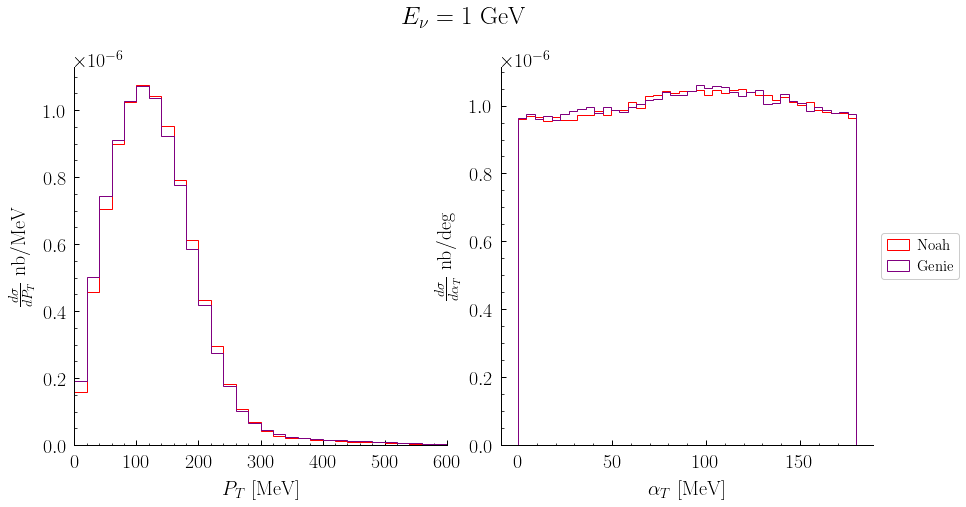

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(Ar_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ar_TKI[0])*Ar_TKI_weight[0],histtype='step',label='Noah',color='red')
ax[0].hist(Ar_genie_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ar_genie_TKI[0])*Ar_genie_TKI_weight[0],histtype='step',label='Genie',color='purple')

ax[0].set_ylabel(r'$\frac{d\sigma}{dP_{T}}$ $\rm{nb}/\rm{MeV}$')
ax[0].set_xlabel(r'$P_{T}$ [MeV]')
ax[0].set_xlim([0,600])
ax[0] = fix_ax(ax[0])

ax[1].hist(Ar_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ar_TKI[1])*Ar_TKI_weight[1],histtype='step',label='Noah',color='red')
ax[1].hist(Ar_genie_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ar_genie_TKI[1])*Ar_genie_TKI_weight[1],histtype='step',label='Genie',color='purple')
ax[1].set_ylabel(r'$\frac{d\sigma}{d\alpha_{T}}$ $\rm{nb}/\rm{deg}$')
ax[1].set_xlabel(r'$\alpha_{T}$ [MeV]')

ax[1] = fix_ax(ax[1])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV',fontsize=25,y=1.1)
plt.show()

In [123]:
#Now lets get flux folded events
flux_probe_p4 = []
flux_lepton_p4 = []
flux_innuc_p4 = []
flux_outnuc_p4 = []

with open('flux_fold/test.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        flux_probe_p4.append(p1)
        flux_lepton_p4.append(p2)
        flux_innuc_p4.append(p3)
        flux_outnuc_p4.append(p4)

#total cross section
flux_noah_xsec = 3.800e-05 #nb
flux_noah_numevents = 40002    

In [43]:
def get_double_diff_xsec_cosT(probeP4, leptonP4, low_cosines, high_cosines, xsec, events, bins, low_bins, high_bins):
    mmu = 105.6
    double_dif_cosines = []
    weights = []
    
    for low_cos,high_cos,low_bin,high_bin in zip(low_cosines,high_cosines,low_bins,high_bins):
        double_dif = []

        delta_cos = (high_cos - low_cos)

        for probe,lep in zip(probeP4, leptonP4):
            Tmu = lep[0] - mmu
            probe_3 = [probe[1], probe[2], probe[3]]
            lep_3 = [lep[1], lep[2], lep[3]]
            cos_theta = np.dot(lep_3,probe_3)/(np.sqrt(np.dot(lep_3,lep_3))*np.sqrt(np.dot(probe_3,probe_3)))
            if cos_theta < high_cos and cos_theta > low_cos:
                double_dif.append(Tmu)

        bin_width = delta_cos*(high_bin - low_bin)/bins

        double_dif = np.array(double_dif)
        double_dif_cosines.append(double_dif)
        weight = (xsec)/events/bin_width
        weights.append(weight)
    
    return double_dif_cosines,weights


#plt.hist(np.array(flux_probe_p4)[:,0],bins=40,range=(0,3000))

In [124]:
numbins = 25
omegalows = [0,0,0]
omegahighs = [800,1200,1800]


cos_lows = [0.2,0.5,0.8]
cos_highs = [0.3,0.6,0.9]

flux_dsig,flux_weights = get_double_diff_xsec_cosT(flux_probe_p4, flux_lepton_p4, cos_lows, cos_highs, flux_noah_xsec, flux_noah_numevents, numbins, omegalows, omegahighs)



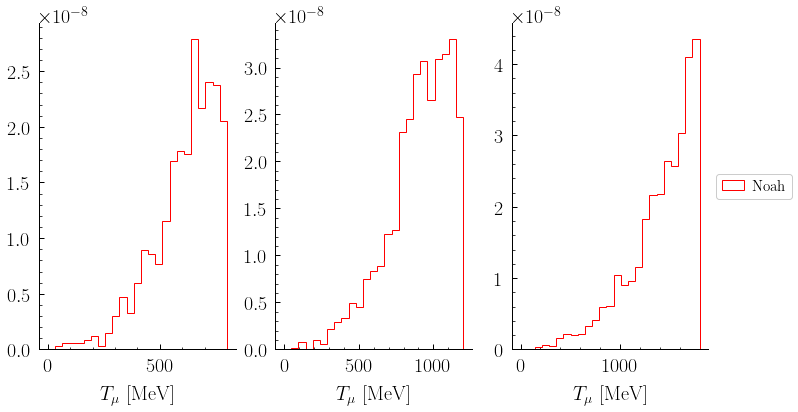

In [125]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i in range(0,3):


    ax[i].hist(flux_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(flux_dsig[i])*flux_weights[i],histtype='step',color='red',label='Noah')


      
    #ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax[i].set_xlabel(r'$T_{\mu}$ [MeV]')
    ax[i] = fix_ax(ax[i])
    
#ax[0].set_ylabel(r'$\frac{d\sigma}{d$T_{\mu}$ d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
#ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax[2].set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

#fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

(array([  13.,   36.,   44.,   84.,  165.,  219.,  263.,  363.,  443.,
         549.,  618.,  742.,  838.,  899.,  999., 1062., 1063., 1059.,
        1141., 1140., 1157., 1183., 1190., 1174., 1224., 1221., 1199.,
        1214., 1167., 1250., 1140., 1189., 1056., 1082., 1011.,  967.,
         868.,  879.,  813.,  819.,  712.,  662.,  619.,  623.,  580.,
         536.,  419.,  405.,  380.,  334.,  316.,  248.,  223.,  164.,
         116.,   71.,   43.,    7.]),
 array([ 243.03777169,  359.22673529,  475.4156989 ,  591.60466251,
         707.79362611,  823.98258972,  940.17155333, 1056.36051693,
        1172.54948054, 1288.73844414, 1404.92740775, 1521.11637136,
        1637.30533496, 1753.49429857, 1869.68326218, 1985.87222578,
        2102.06118939, 2218.25015299, 2334.4391166 , 2450.62808021,
        2566.81704381, 2683.00600742, 2799.19497103, 2915.38393463,
        3031.57289824, 3147.76186184, 3263.95082545, 3380.13978906,
        3496.32875266, 3612.51771627, 3728.70667988, 3844.89

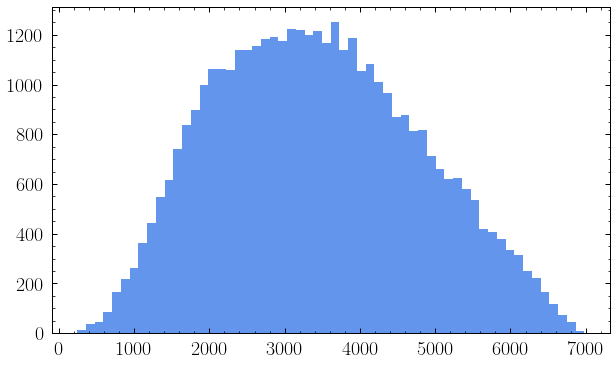

In [128]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

flux_df = pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/flux_fold/flux_nu_noheader.dat',sep="\s+|\t+|\s+\t+|\t+\s+",header=None, engine='python')

flux_df.columns = ['Elo','Ehigh','numu', 'numub', 'nue', 'nueb']

weight = 1./(5000./100.)

ax.hist(np.array(flux_probe_p4)[:,0],bins="auto")

#ax.plot(1000.*(flux_df['Elo'] + flux_df['Ehigh'])/2, flux_df['numu']/2.5967881461245138E-011,linestyle='dotted',color='red',linewidth=2.5)
#ax.set_xlim([0,3000])
#ax.set_ylim([0,2.0])

In [71]:
highE_probe_p4 = []
highE_lepton_p4 = []
highE_innuc_p4 = []
highE_outnuc_p4 = []

with open('C12_CC_20000.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        highE_probe_p4.append(p1)
        highE_lepton_p4.append(p2)
        highE_innuc_p4.append(p3)
        highE_outnuc_p4.append(p4)

In [76]:
highE_genie_xsec = 4.51393e-05
highE_genie_numevents = 300000

#Get GENIE events

highE_genie_file = uproot.open("/Users/noah/Desktop/C12_20GeV.gst.root")
highE_gst = genie_file["gst"]
highE_branches = gst.arrays()
highE_genie_probe_p4 = np.transpose([branches['Ev'],branches['pxv'], branches['pyv'], branches['pzv']])*1.e3
highE_genie_lepton_p4 = np.transpose([branches['El'],branches['pxl'], branches['pyl'], branches['pzl']])*1.e3
highE_genie_neutron_p4 = np.transpose([branches['En'],branches['pxn'], branches['pyn'], branches['pzn']])*1.e3
highE_genie_proton_p4 = np.transpose([branches['Ei'][branches['pdgi'] == 2212],branches['pxi'][branches['pdgi'] == 2212], branches['pyi'][branches['pdgi'] == 2212], branches['pzi'][branches['pdgi'] == 2212]])*1.e3

Noahs highE mean=  5.086102985220326
Noahs mean =  -14.267701593893241
Achilles mean =  -17.64681489372548
GENIE mean =  -15.704810453095687
GENIE highE mean =  -15.704810453095687


Text(67.3043737352117, 0.5, '$\\frac{d\\sigma}{dP_{N_{L}}}$ [nb/MeV]')

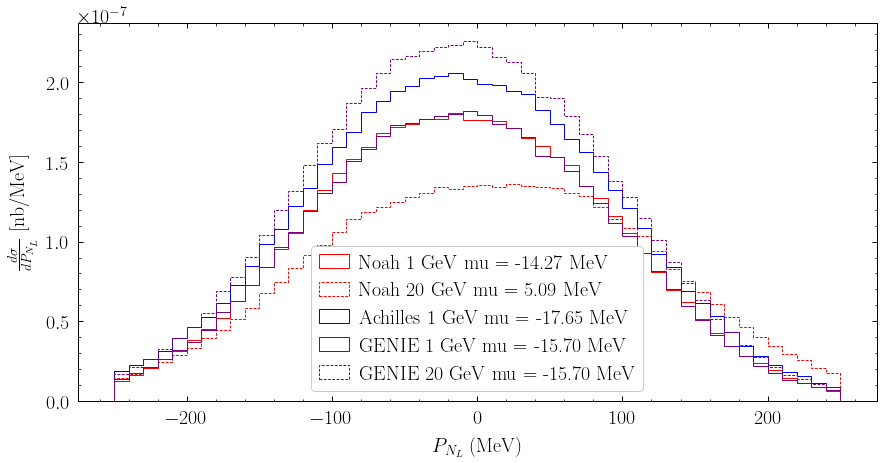

In [77]:
#Look at longitudinal nucleon momentum
#interesting we observe the same shift as https://arxiv.org/pdf/2310.15633.pdf
fig,ax = plt.subplots(1,1,figsize=(12,6))
fig.tight_layout()

from scipy.stats import norm
noah_long_highE = parallel_mom(highE_probe_p4,highE_innuc_p4)
noah_long = parallel_mom(probe_p4,innuc_p4)
Ac_long = parallel_mom(Ac_probe_p4,Ac_neutron_p4)
genie_long = parallel_mom(genie_probe_p4,genie_neutron_p4)
genie_long_highE = parallel_mom(highE_genie_probe_p4,highE_genie_neutron_p4)


noah_mean_HighE,noah_std_HighE=norm.fit(noah_long_highE)
print('Noahs highE mean= ',noah_mean_HighE)
noah_mean,noah_std=norm.fit(noah_long)
print('Noahs mean = ',noah_mean)
achilles_mean,noah_std=norm.fit(Ac_long)
print('Achilles mean = ',achilles_mean)
genie_mean,noah_std=norm.fit(genie_long)
print('GENIE mean = ',genie_mean)
genie_mean_HighE,noah_std=norm.fit(genie_long_highE)
print('GENIE highE mean = ',genie_mean_HighE)

noah_xsec_HighE = 4.4418e-05

ax.hist(noah_long, bins = 50, range = (-250,250), weights = np.ones_like(noah_long)*noah_xsec/noah_numevents/10.,histtype='step',label='Noah 1 GeV mu = {:.2f} MeV'.format(noah_mean),color='red')

ax.hist(noah_long_highE, bins = 50, range = (-250,250), weights = np.ones_like(noah_long_highE)*noah_xsec_HighE/noah_numevents/10.,histtype='step',label='Noah 20 GeV mu = {:.2f} MeV'.format(noah_mean_HighE),color='red',linestyle='--')

ax.hist(Ac_long, bins = 50, range = (-250,250), weights = np.ones_like(Ac_long)*achilles_xsec/achilles_numevents/10.,histtype='step',label='Achilles 1 GeV mu = {:.2f} MeV'.format(achilles_mean),color='blue')

ax.hist(genie_long, bins = 50, range = (-250,250), weights = np.ones_like(genie_long)*genie_xsec/genie_numevents/10.,histtype='step',label='GENIE 1 GeV mu = {:.2f} MeV'.format(genie_mean),color='purple')

ax.hist(genie_long_highE, bins = 50, range = (-250,250), weights = np.ones_like(genie_long_highE)*highE_genie_xsec/highE_genie_numevents/10.,histtype='step',label='GENIE 20 GeV mu = {:.2f} MeV'.format(genie_mean_HighE),color='purple',linestyle='--')

ax.legend()

ax.set_xlabel(r'$P_{N_{L}}$ (MeV)')
ax.set_ylabel(r'$\frac{d\sigma}{dP_{N_{L}}}$ [nb/MeV]')

In [3]:
#Get Noah's events

#Useful constants
tm15fm2_to_nb = 1.e-8
tm38cm2_to_nb = 1.
GeVm2_to_nb = 389379.09

#GENIE total cross section
noah_xsec =  150071.28326165327#nb

noah_numevents = 400001

probe_p4 = []
lepton_p4 = []
innuc_p4 = []
outnuc_p4 = []

with open('/Users/noah/Physics/Fermilab/Event_Generator/EM/C12_EM_p_730.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        probe_p4.append(p1)
        lepton_p4.append(p2)
        innuc_p4.append(p3)
        outnuc_p4.append(p4)

In [8]:
numbins = 25
omegalows = [30,30,30]
omegahighs = [200,250,350]

dtheta = 1.0
angles = [18,25,37.1]

noah_dsig,noah_weights = get_double_diff_xsec(probe_p4, lepton_p4, angles, dtheta, noah_xsec, noah_numevents, numbins, omegalows, omegahighs)


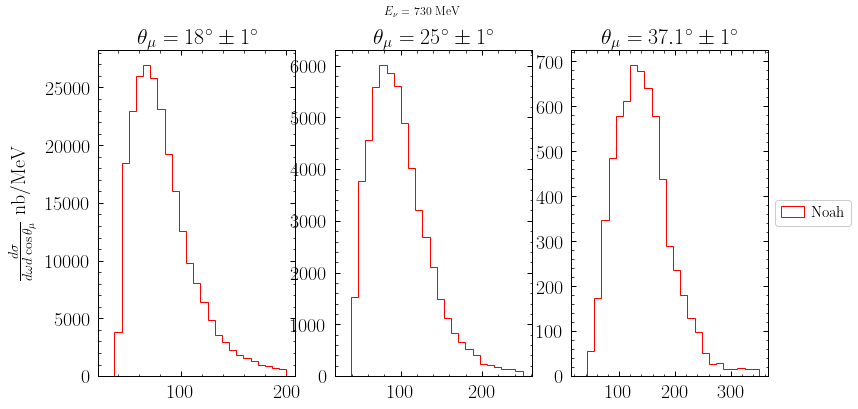

In [9]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i,angle in enumerate(angles):

    ax[i].hist(noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(noah_dsig[i])*noah_weights[i],histtype='step',color='red',label='Noah')

    
ax[0].set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].set_title(r'$\theta_{\mu} = {37.1}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 730$ MeV')
plt.show()

In [3]:
#Useful constants
tm15fm2_to_nb = 1.e-8
tm38cm2_to_nb = 1.
GeVm2_to_nb = 389379.09

noah_numevents = 200000

def get_double_diff_xsec(file, angles, delta, xsec, events, bins, low_bins, high_bins):
    
    
    angular_dif = [] 
    double_dif_angles = []
    p1 = []
    p2 = []
    pp1 = []
    pp2 = []
    pp12cos = []
    p12cos = []
    nuc1cos = []
    nuc2cos = []
    nucp1cos = []
    nucp2cos = []
    weights = []
    
    for angle,low_bin,high_bin in zip(angles,low_bins,high_bins):
        double_dif = []
        angular = []

        high_cos = math.cos((angle + delta)*np.pi/180)
        low_cos = math.cos((angle - delta)*np.pi/180)
        delta_cos = (low_cos - high_cos)
        #print(delta_cos)

        #for probe,lep,nuc1,nuc2,nucp1,nucp2 in zip(probeP4, leptonP4, innuc1_p4, innuc2_p4,outnuc1_p4,outnuc2_p4):
        with open(file, 'r') as file:
            for probe,lep,nuc1,nucp1,nuc2,nucp2 in itertools.zip_longest(*[file]*6):
                probe = [float(x) for x in probe.split()]
                lep = [float(x) for x in lep.split()]
                nuc1 = [float(x) for x in nuc1.split()]
                nucp1 = [float(x) for x in nucp1.split()]
                nuc2 = [float(x) for x in nuc2.split()]
                nucp2 = [float(x) for x in nucp2.split()]

                omega = probe[0] - lep[0]
                if omega < 0:
                    print('negative omega!')
                    print(probe[0])
                    print(lep[0])
                probe_3 = [probe[1], probe[2], probe[3]]
                probe_mom = np.sqrt(np.dot(probe_3,probe_3))
                lep_3 = [lep[1], lep[2], lep[3]]
                
                nuc1_3 = [nuc1[1],nuc1[2],nuc1[3]]
                nuc2_3 = [nuc2[1],nuc2[2],nuc2[3]]
                nucp1_3 = [nucp1[1],nucp1[2],nucp1[3]]
                nucp2_3 = [nucp2[1],nucp2[2],nucp2[3]]
                
                cos_theta = np.dot(lep_3,probe_3)/(np.sqrt(np.dot(lep_3,lep_3))*np.sqrt(np.dot(probe_3,probe_3)))
                
                nuc1_mom = np.sqrt(np.dot(nuc1_3,nuc1_3))
                nuc2_mom = np.sqrt(np.dot(nuc2_3,nuc2_3))
                nucp1_mom = np.sqrt(np.dot(nucp1_3,nucp1_3))
                nucp2_mom = np.sqrt(np.dot(nucp2_3,nucp2_3))

                z = np.array([0,0,1])
                nuc1cos.append(np.dot(probe_3,nuc1_3)/nuc1_mom/probe_mom)
                nuc2cos.append(np.dot(probe_3,nuc2_3)/nuc2_mom/probe_mom)
                nucp1cos.append(np.dot(probe_3,nucp1_3)/nucp1_mom/probe_mom)
                nucp2cos.append(np.dot(probe_3,nucp2_3)/nucp2_mom/probe_mom)

                angular.append(cos_theta)
                p1.append(nuc1_mom)
                p2.append(nuc2_mom)
                pp1.append(nucp1_mom)
                pp2.append(nucp2_mom)
                pp12cos.append(np.dot(nucp1_3,nucp2_3)/(nucp1_mom*nucp2_mom))
                p12cos.append(np.dot(nuc1_3,nuc2_3)/(nuc1_mom*nuc2_mom))
                if cos_theta < low_cos and cos_theta > high_cos:
                    #print(cos_theta)
                    double_dif.append(omega)

        bin_width = 2*np.pi*(high_bin - low_bin)/bins

        double_dif = np.array(double_dif)
        angular = np.array(angular)
        angular_dif.append(angular)
        double_dif_angles.append(double_dif)
        weight = (xsec)/events/bin_width
        weights.append(weight)
    
    return angular_dif,double_dif_angles,p1,p2,pp1,pp2,p12cos,pp12cos,nuc1cos,nuc2cos,nucp1cos,nucp2cos,weights

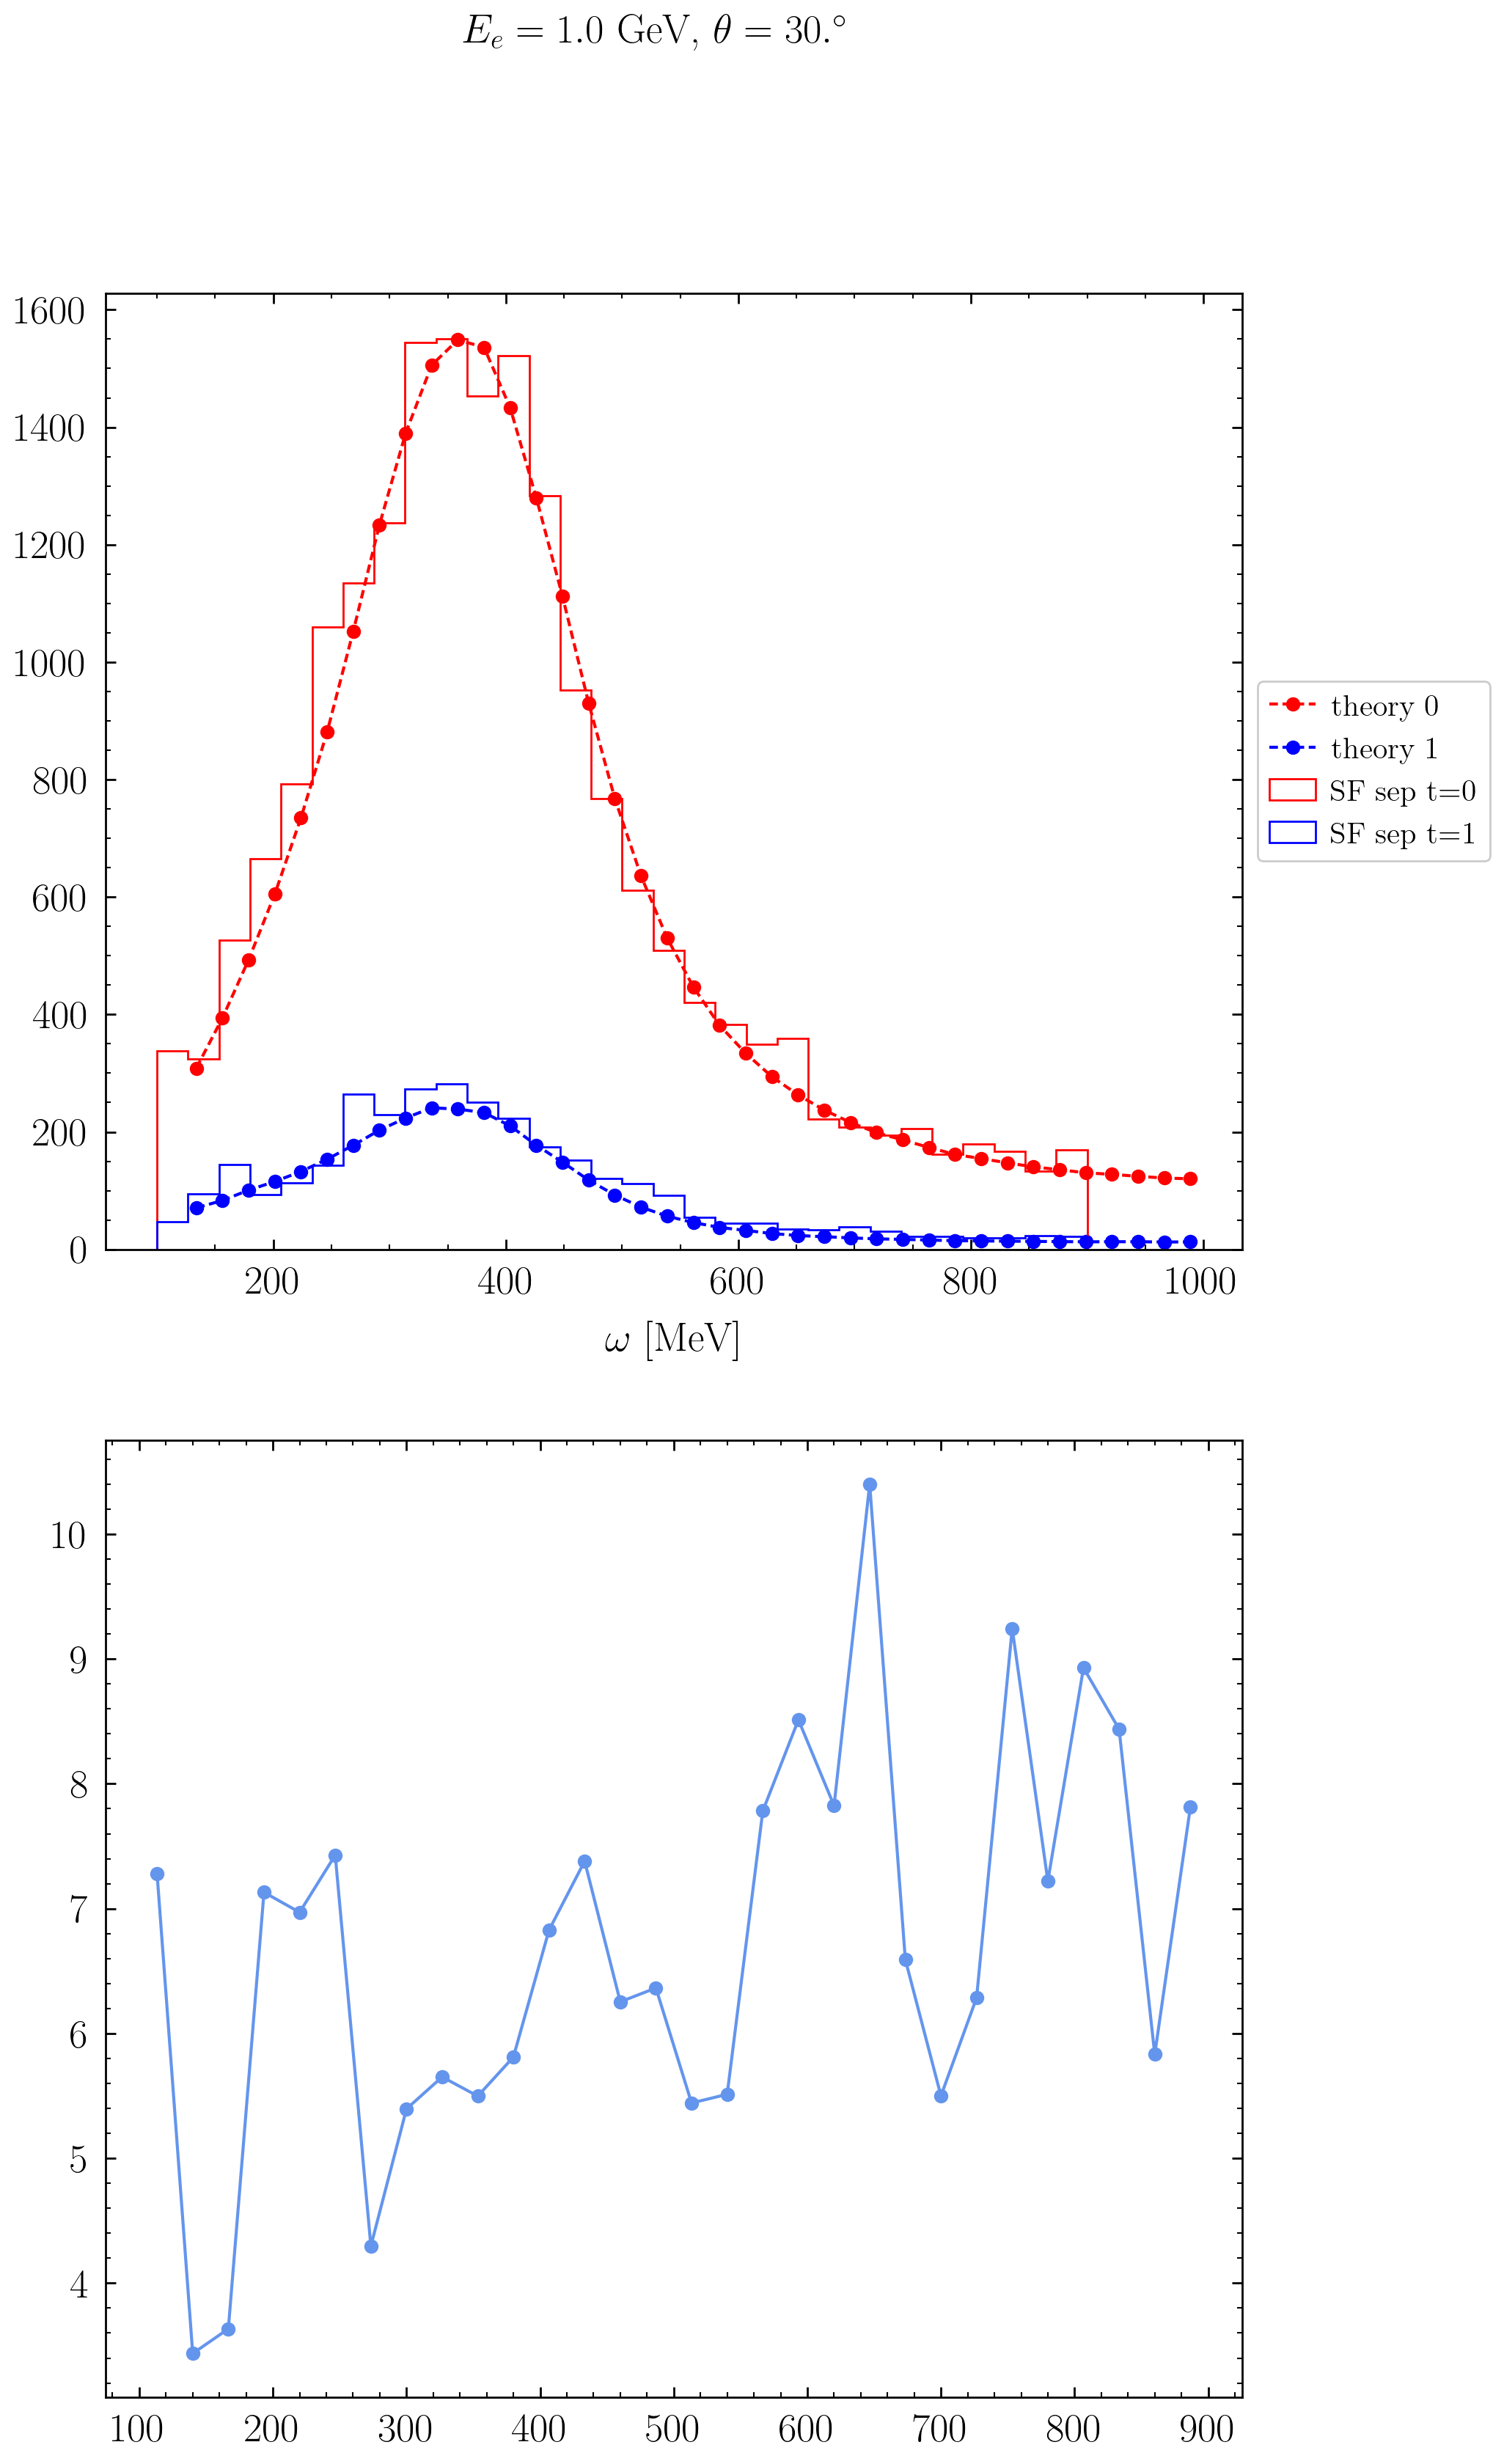

In [150]:
numbins = 30
omegalows = [100]
omegahighs = [900]

dtheta = 1
angles = [30.0]

noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,noah_weights0SF = get_double_diff_xsec('test_0_SF_1000_30p0.out', angles, dtheta, 3137916.4312864826, noah_numevents, numbins, omegalows, omegahighs)
noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,noah_weights1SF = get_double_diff_xsec('test_1_SF_1000_30p0.out', angles, dtheta, 526239.09769619268, noah_numevents, numbins, omegalows, omegahighs)
 
fig,ax = plt.subplots(2,1,figsize=(10,19))

#ax.hist(noah_dsig0[i],weights=np.ones_like(noah_dsig0[i])*noah_weights0[i],bins=30,histtype='step',color='red',label='t=0',linestyle='--')
#ax.hist(noah_dsig1[i],weights=np.ones_like(noah_dsig1[i])*noah_weights1[i],bins=30,histtype='step',color='blue',label='t=1',linestyle='--')

pred0 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_0_1000_30p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred0.columns = ['w','sig','sigerr']
pred1 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_1_1000_30p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred1.columns = ['w','sig','sigerr']


ax[0].plot(pred0['w'], pred0['sig'], marker='o', label='theory 0',color='red',linestyle='--')  
ax[0].plot(pred1['w'], pred1['sig'], marker='o', label='theory 1',color='blue',linestyle='--')

n0, bins0, patches0 = ax[0].hist(noah_dsig0SF[i],weights=np.ones_like(noah_dsig0SF[i])*noah_weights0SF[i]*1.1,bins=30,histtype='step',color='red',label='SF sep t=0',range=(100,900))
n1, bins1, patches1 = ax[0].hist(noah_dsig1SF[i],weights=np.ones_like(noah_dsig1SF[i])*noah_weights1SF[i]*1.1,bins=30,histtype='step',color='blue',label='SF sep t=1',range=(100,900))

# Calculate the ratio, handling any division by zero
ratio = np.divide(n0, n1, out=np.zeros_like(n0, dtype=float), where=(n1 != 0))

bin_centers = 0.5 * (bins1[1:] + bins1[:-1])
ax[1].plot(bin_centers, ratio, marker='o', linestyle='-')


ax[0].set_xlabel(r'$\omega$ [MeV]')
ax[0].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{e} = 1.0$ GeV, $\theta = 30.^\circ$',fontsize=20)
plt.show()

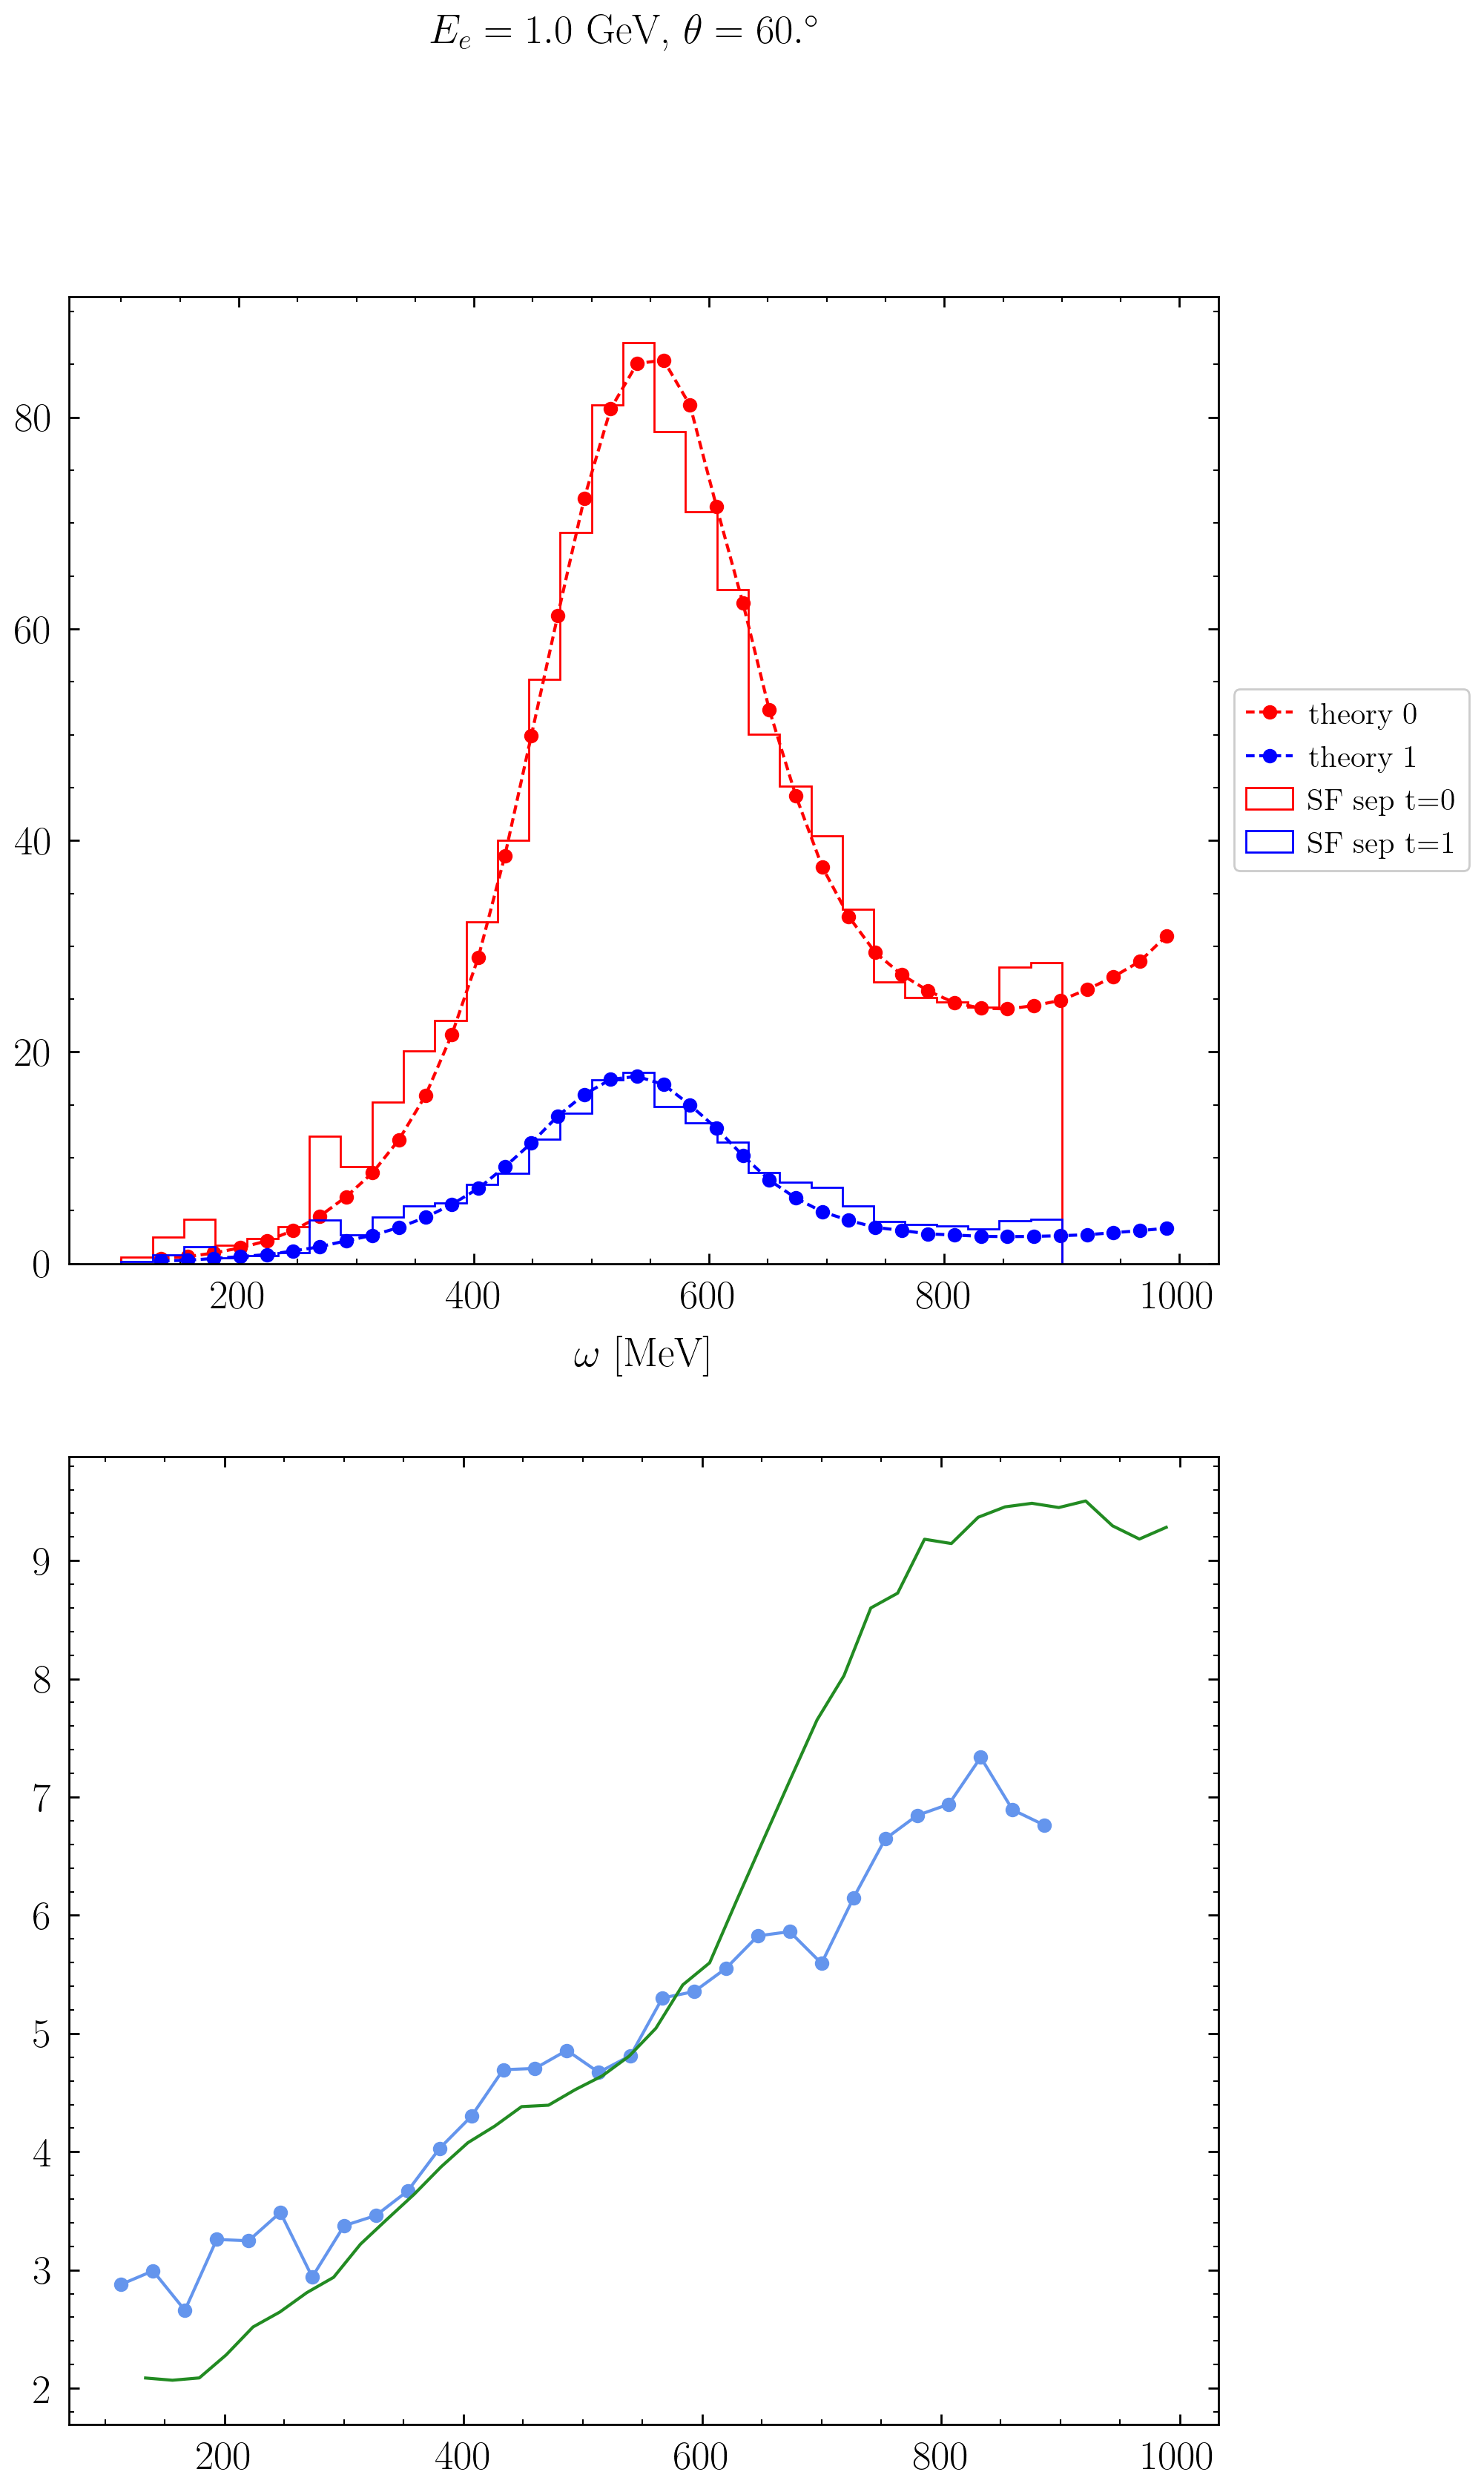

In [153]:
numbins = 30
omegalows = [100]
omegahighs = [900]

dtheta = 1
angles = [60.0]

noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,noah_weights0SF = get_double_diff_xsec('test_0_SF_1000_60p0.out', angles, dtheta, 172082.01837993317, noah_numevents, numbins, omegalows, omegahighs)
noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,noah_weights1SF = get_double_diff_xsec('test_1_SF_1000_60p0.out', angles, dtheta, 32844.723010277870, noah_numevents, numbins, omegalows, omegahighs)
 
fig,ax = plt.subplots(2,1,figsize=(10,19))

pred0 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_0_1000_60p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred0.columns = ['w','sig','sigerr']
pred1 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_1_1000_60p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred1.columns = ['w','sig','sigerr']


ax[0].plot(pred0['w'], pred0['sig'], marker='o', label='theory 0',color='red',linestyle='--')  
ax[0].plot(pred1['w'], pred1['sig'], marker='o', label='theory 1',color='blue',linestyle='--')

n0, bins0, patches0 = ax[0].hist(noah_dsig0SF[i],weights=np.ones_like(noah_dsig0SF[i])*noah_weights0SF[i]*1.1,bins=30,histtype='step',color='red',label='SF sep t=0',range=(100,900))
n1, bins1, patches1 = ax[0].hist(noah_dsig1SF[i],weights=np.ones_like(noah_dsig1SF[i])*noah_weights1SF[i]*1.1,bins=30,histtype='step',color='blue',label='SF sep t=1',range=(100,900))

# Calculate the ratio, handling any division by zero
ratio = np.divide(n0, n1, out=np.zeros_like(n0, dtype=float), where=(n1 != 0))

bin_centers = 0.5 * (bins1[1:] + bins1[:-1])
ax[1].plot(bin_centers, ratio, marker='o', linestyle='-')
ax[1].plot(pred0['w'],pred0['sig']/pred1['sig'])

ax[0].set_xlabel(r'$\omega$ [MeV]')
ax[0].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{e} = 1.0$ GeV, $\theta = 60.^\circ$',fontsize=20)
plt.show()

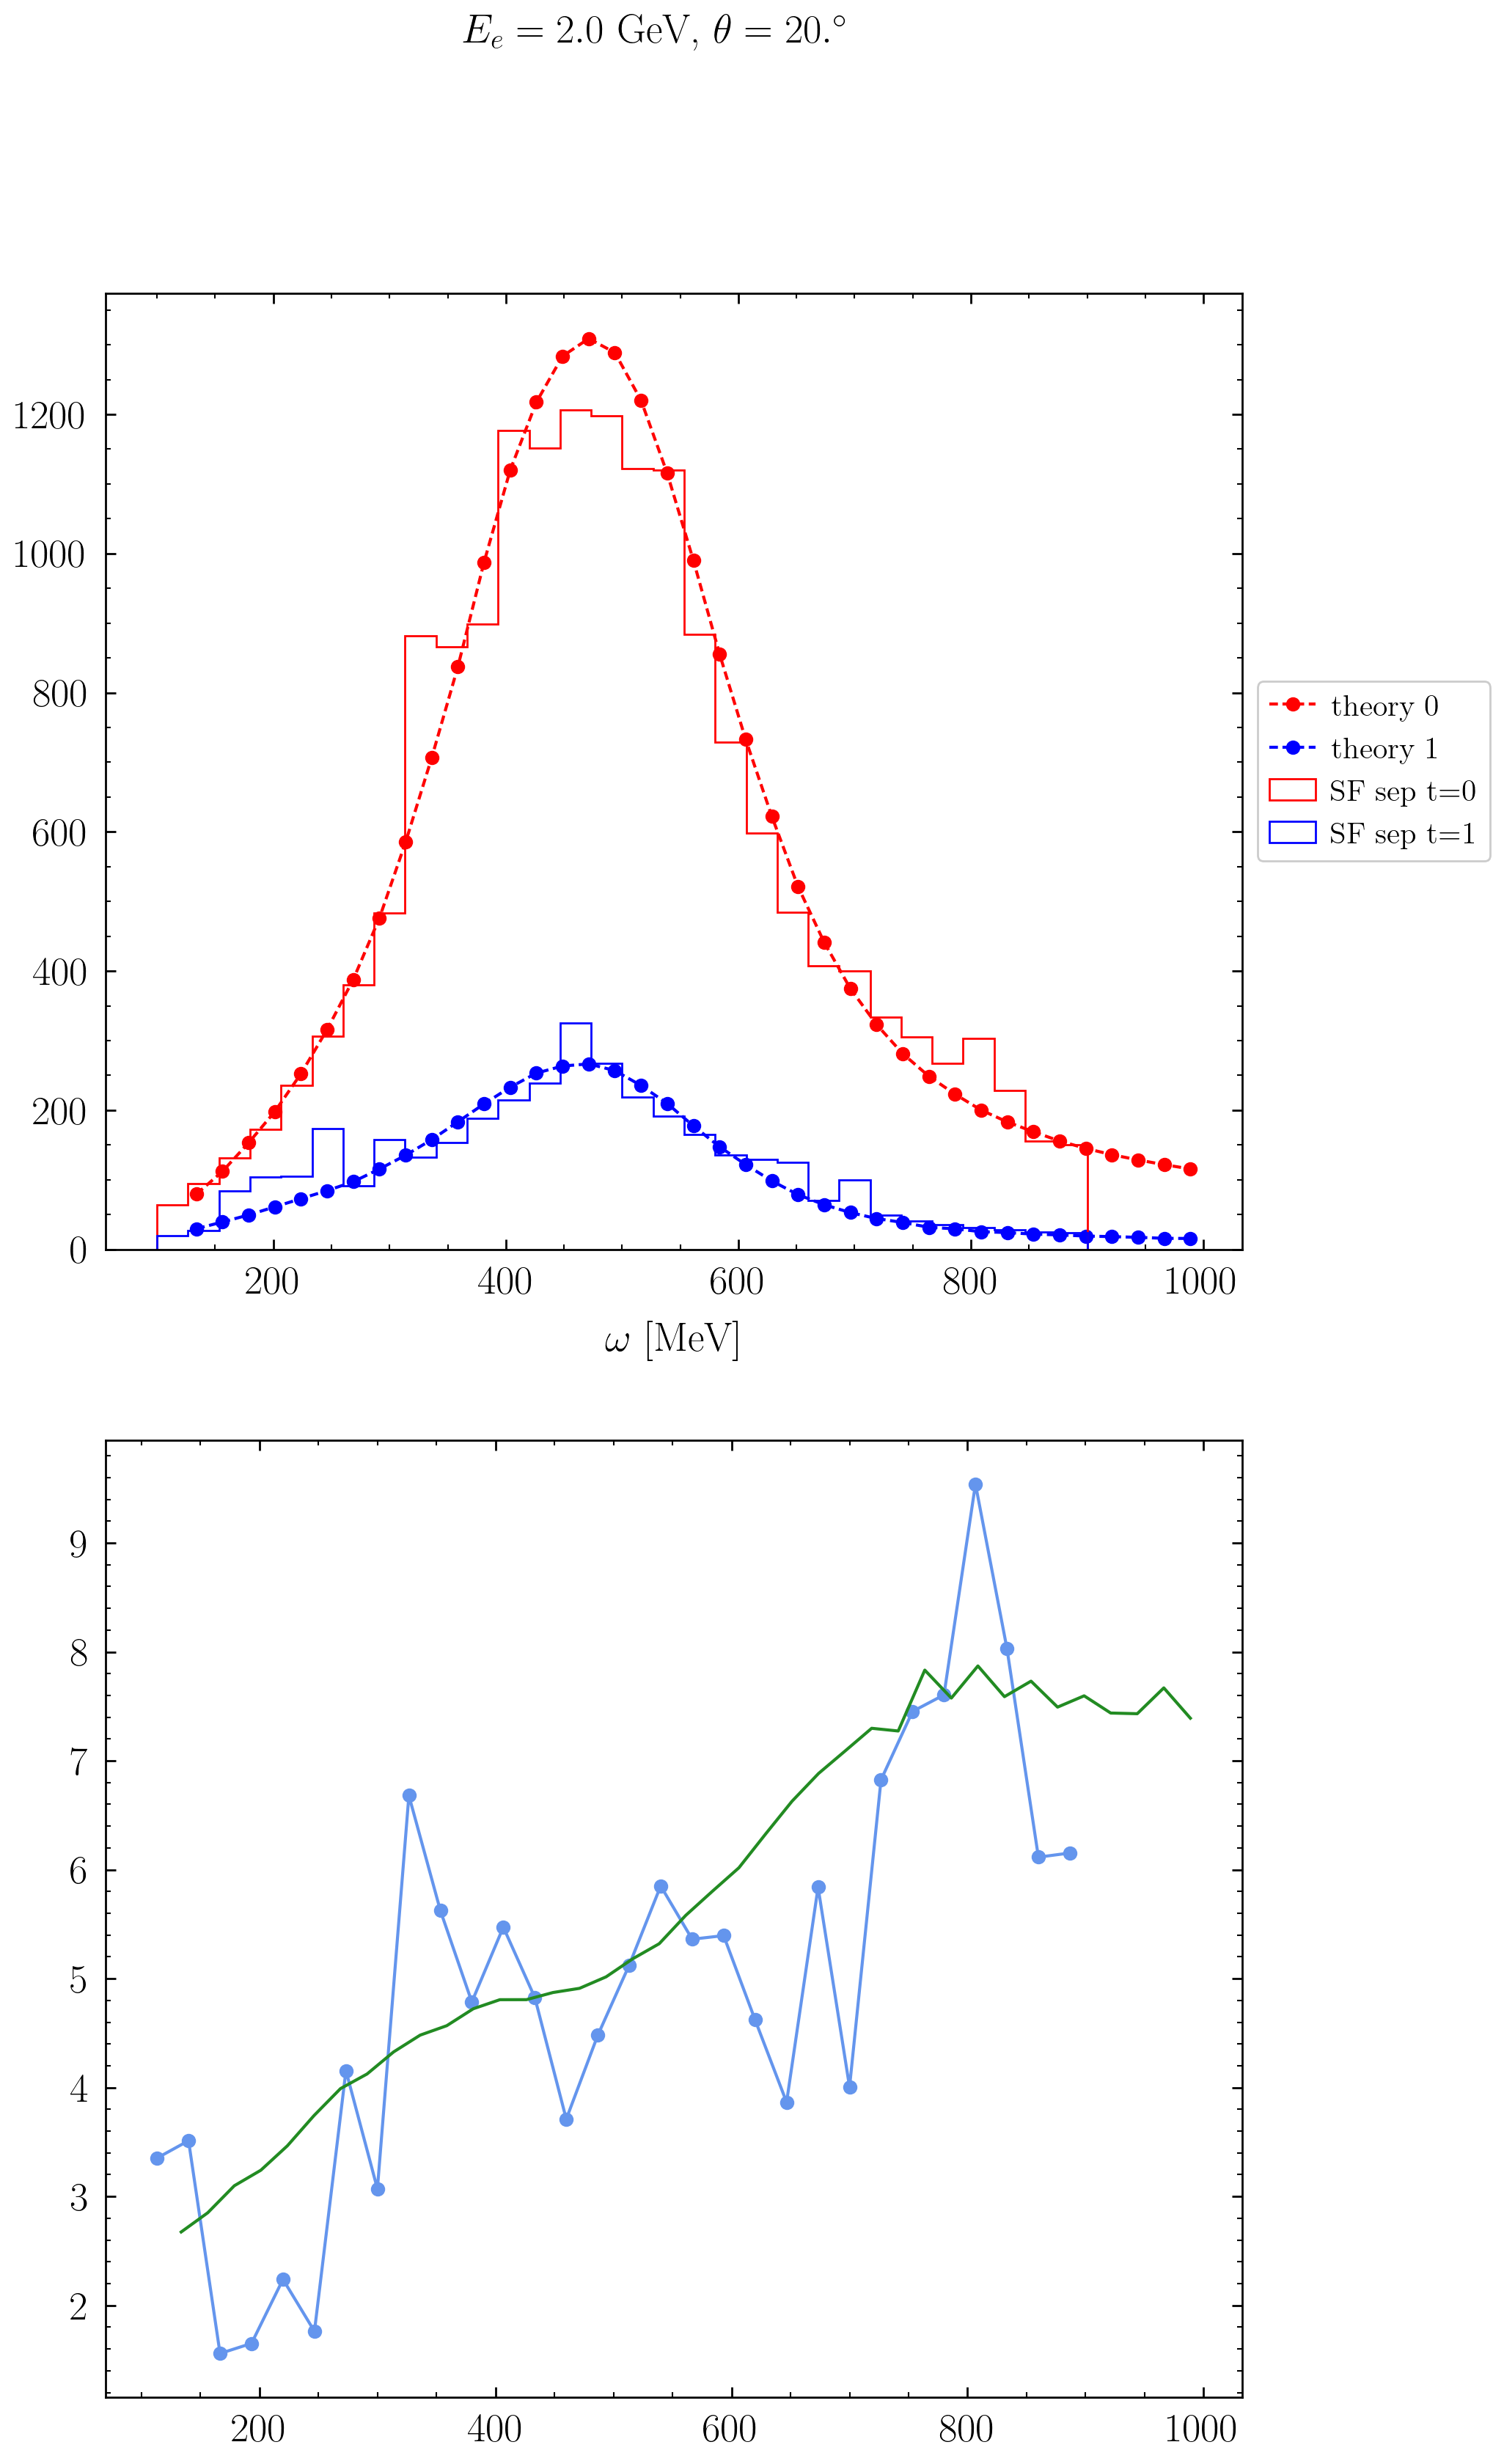

In [155]:
numbins = 30
omegalows = [100]
omegahighs = [900]

dtheta = 1
angles = [20.0]

noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,noah_weights0SF = get_double_diff_xsec('test_0_SF_2000_20p0.out', angles, dtheta, 3303978.6730928444 , noah_numevents, numbins, omegalows, omegahighs)
noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,noah_weights1SF = get_double_diff_xsec('test_1_SF_2000_20p0.out', angles, dtheta, 691134.20026444015, noah_numevents, numbins, omegalows, omegahighs)
 
fig,ax = plt.subplots(2,1,figsize=(10,19))

pred0 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_0_2000_20p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred0.columns = ['w','sig','sigerr']
pred1 =  pd.read_csv('/Users/noah/Physics/Fermilab/MEC/MEC_em/code_n2b/test_SF_1_2000_20p0_cm.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred1.columns = ['w','sig','sigerr']


ax[0].plot(pred0['w'], pred0['sig'], marker='o', label='theory 0',color='red',linestyle='--')  
ax[0].plot(pred1['w'], pred1['sig'], marker='o', label='theory 1',color='blue',linestyle='--')

n0, bins0, patches0 = ax[0].hist(noah_dsig0SF[i],weights=np.ones_like(noah_dsig0SF[i])*noah_weights0SF[i]*1.1,bins=30,histtype='step',color='red',label='SF sep t=0',range=(100,900))
n1, bins1, patches1 = ax[0].hist(noah_dsig1SF[i],weights=np.ones_like(noah_dsig1SF[i])*noah_weights1SF[i]*1.1,bins=30,histtype='step',color='blue',label='SF sep t=1',range=(100,900))

# Calculate the ratio, handling any division by zero
ratio = np.divide(n0, n1, out=np.zeros_like(n0, dtype=float), where=(n1 != 0))

bin_centers = 0.5 * (bins1[1:] + bins1[:-1])
ax[1].plot(bin_centers, ratio, marker='o', linestyle='-')
ax[1].plot(pred0['w'],pred0['sig']/pred1['sig'])

ax[0].set_xlabel(r'$\omega$ [MeV]')
ax[0].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{e} = 2.0$ GeV, $\theta = 20.^\circ$',fontsize=20)
plt.show()

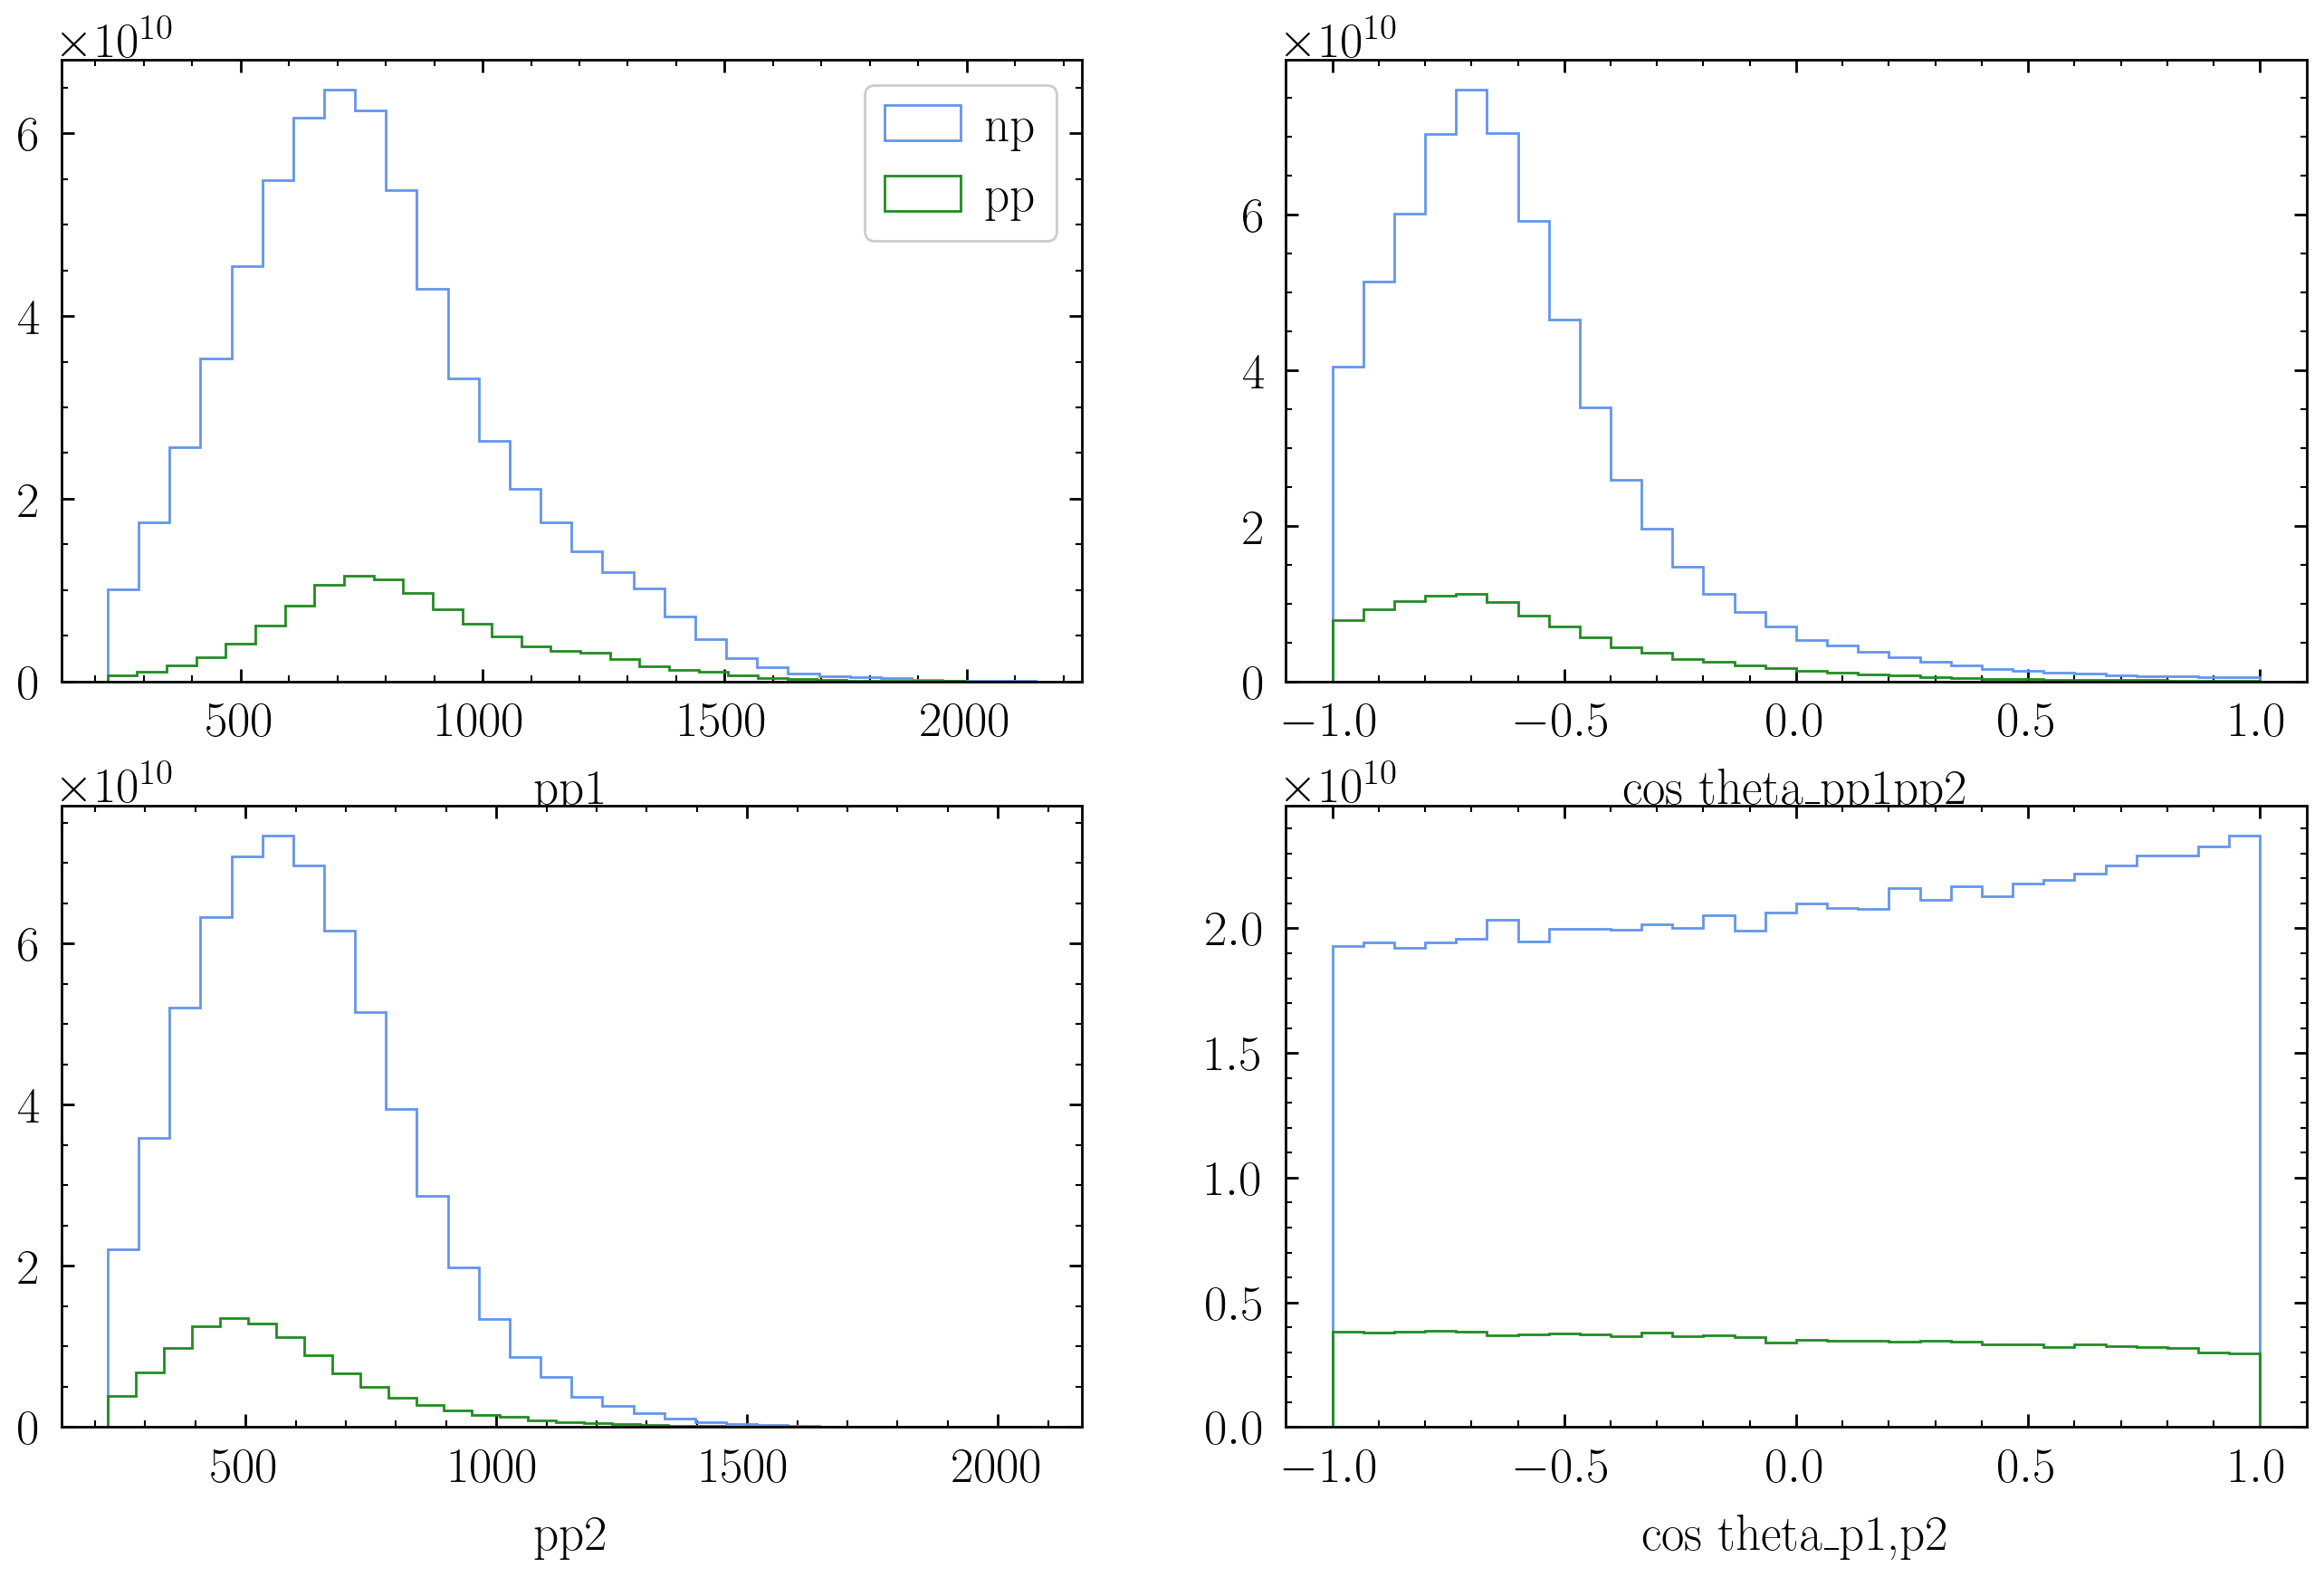

In [152]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

ax[0][0].hist(pp1_0,histtype='step',label='np',weights=np.ones_like(pp1_0)*noah_xsec0SF,bins=30)
ax[0][0].hist(pp1_1,histtype='step',label='pp',weights=np.ones_like(pp1_1)*noah_xsec1SF,bins=30)
ax[0][0].set_xlabel('pp1')


ax[1][0].hist(pp2_0,histtype='step',label='np',weights=np.ones_like(pp2_0)*noah_xsec0SF,bins=30)
ax[1][0].hist(pp2_1,histtype='step',label='pp',weights=np.ones_like(pp2_1)*noah_xsec1SF,bins=30)
ax[1][0].set_xlabel('pp2')

ax[0][1].hist(pp12cos_0,histtype='step',label='np',weights=np.ones_like(pp12cos_0)*noah_xsec0SF,bins=30)
ax[0][1].hist(pp12cos_1,histtype='step',label='pp',weights=np.ones_like(pp12cos_1)*noah_xsec1SF,bins=30)
ax[0][1].set_xlabel('cos theta_{pp1pp2}')


ax[1][1].hist(p12cos_0,histtype='step',label='np',weights=np.ones_like(p12cos_0)*noah_xsec0SF,bins=30)
ax[1][1].hist(p12cos_1,histtype='step',label='pp',weights=np.ones_like(p12cos_1)*noah_xsec1SF,bins=30)
ax[1][1].set_xlabel('cos theta_{p1,p2}')
ax[0][0].legend()

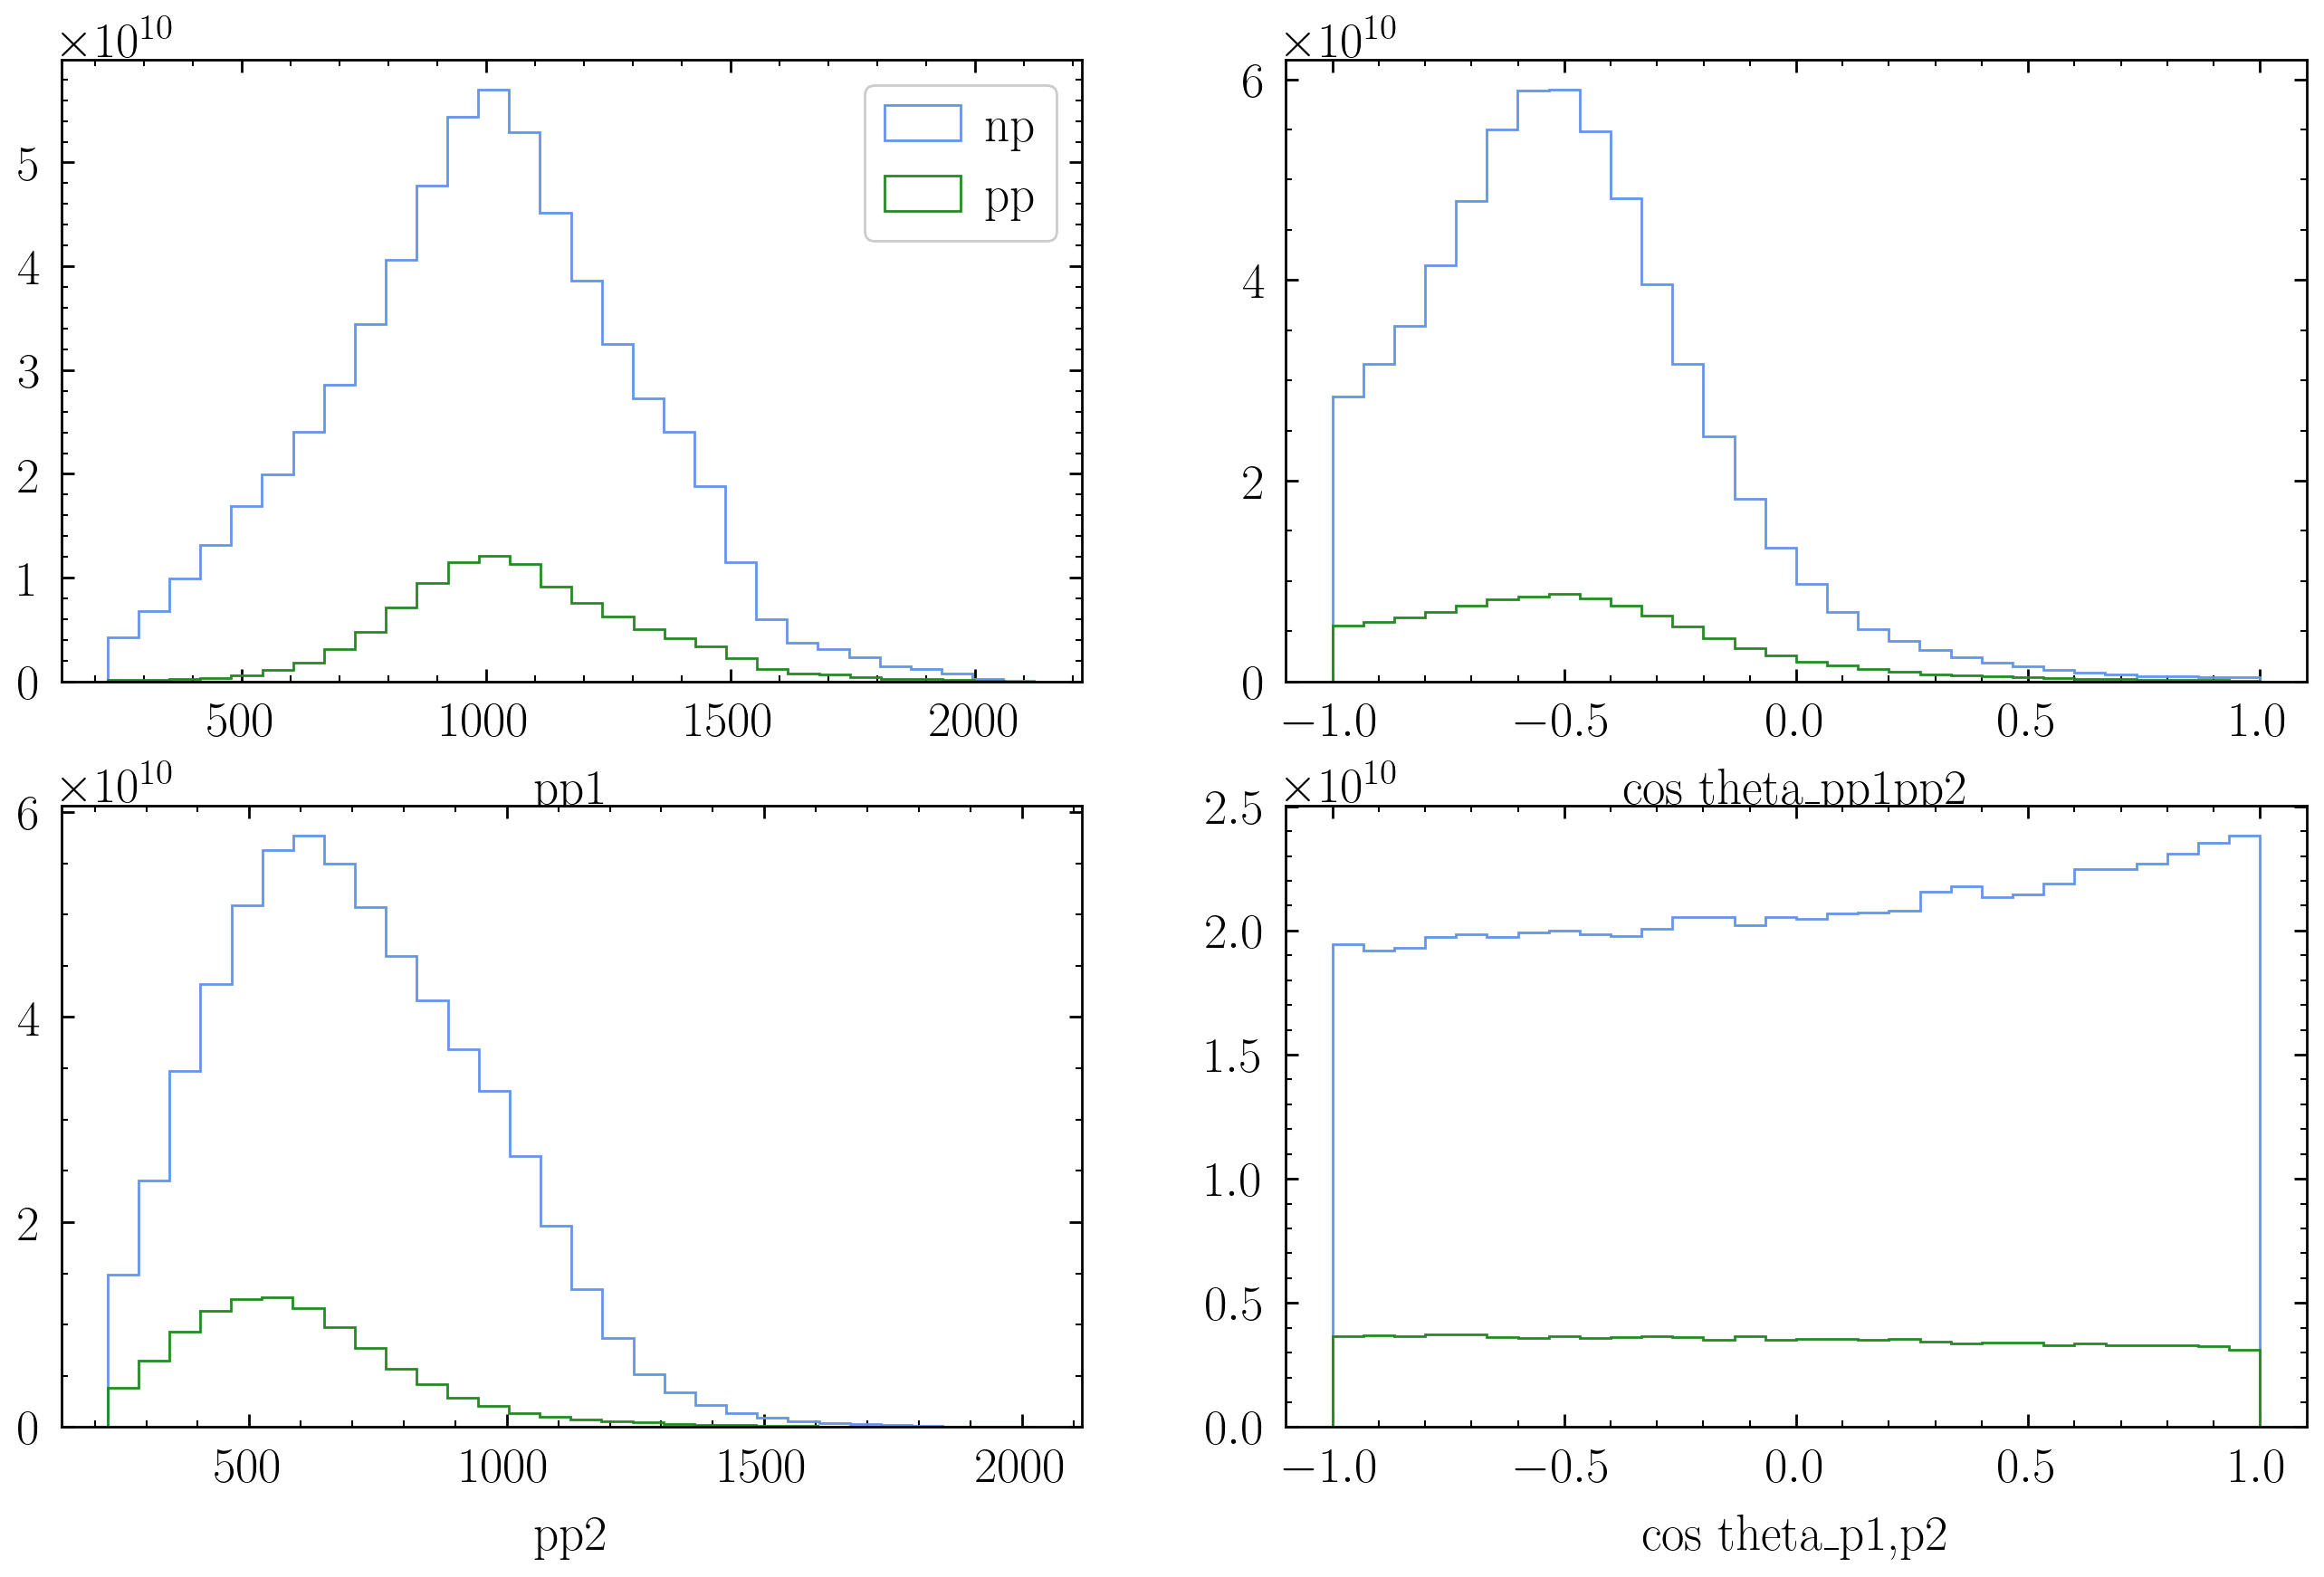

In [154]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

ax[0][0].hist(pp1_0,histtype='step',label='np',weights=np.ones_like(pp1_0)*noah_xsec0SF,bins=30)
ax[0][0].hist(pp1_1,histtype='step',label='pp',weights=np.ones_like(pp1_1)*noah_xsec1SF,bins=30)
ax[0][0].set_xlabel('pp1')


ax[1][0].hist(pp2_0,histtype='step',label='np',weights=np.ones_like(pp2_0)*noah_xsec0SF,bins=30)
ax[1][0].hist(pp2_1,histtype='step',label='pp',weights=np.ones_like(pp2_1)*noah_xsec1SF,bins=30)
ax[1][0].set_xlabel('pp2')

ax[0][1].hist(pp12cos_0,histtype='step',label='np',weights=np.ones_like(pp12cos_0)*noah_xsec0SF,bins=30)
ax[0][1].hist(pp12cos_1,histtype='step',label='pp',weights=np.ones_like(pp12cos_1)*noah_xsec1SF,bins=30)
ax[0][1].set_xlabel('cos theta_{pp1pp2}')


ax[1][1].hist(p12cos_0,histtype='step',label='np',weights=np.ones_like(p12cos_0)*noah_xsec0SF,bins=30)
ax[1][1].hist(p12cos_1,histtype='step',label='pp',weights=np.ones_like(p12cos_1)*noah_xsec1SF,bins=30)
ax[1][1].set_xlabel('cos theta_{p1,p2}')
ax[0][0].legend()

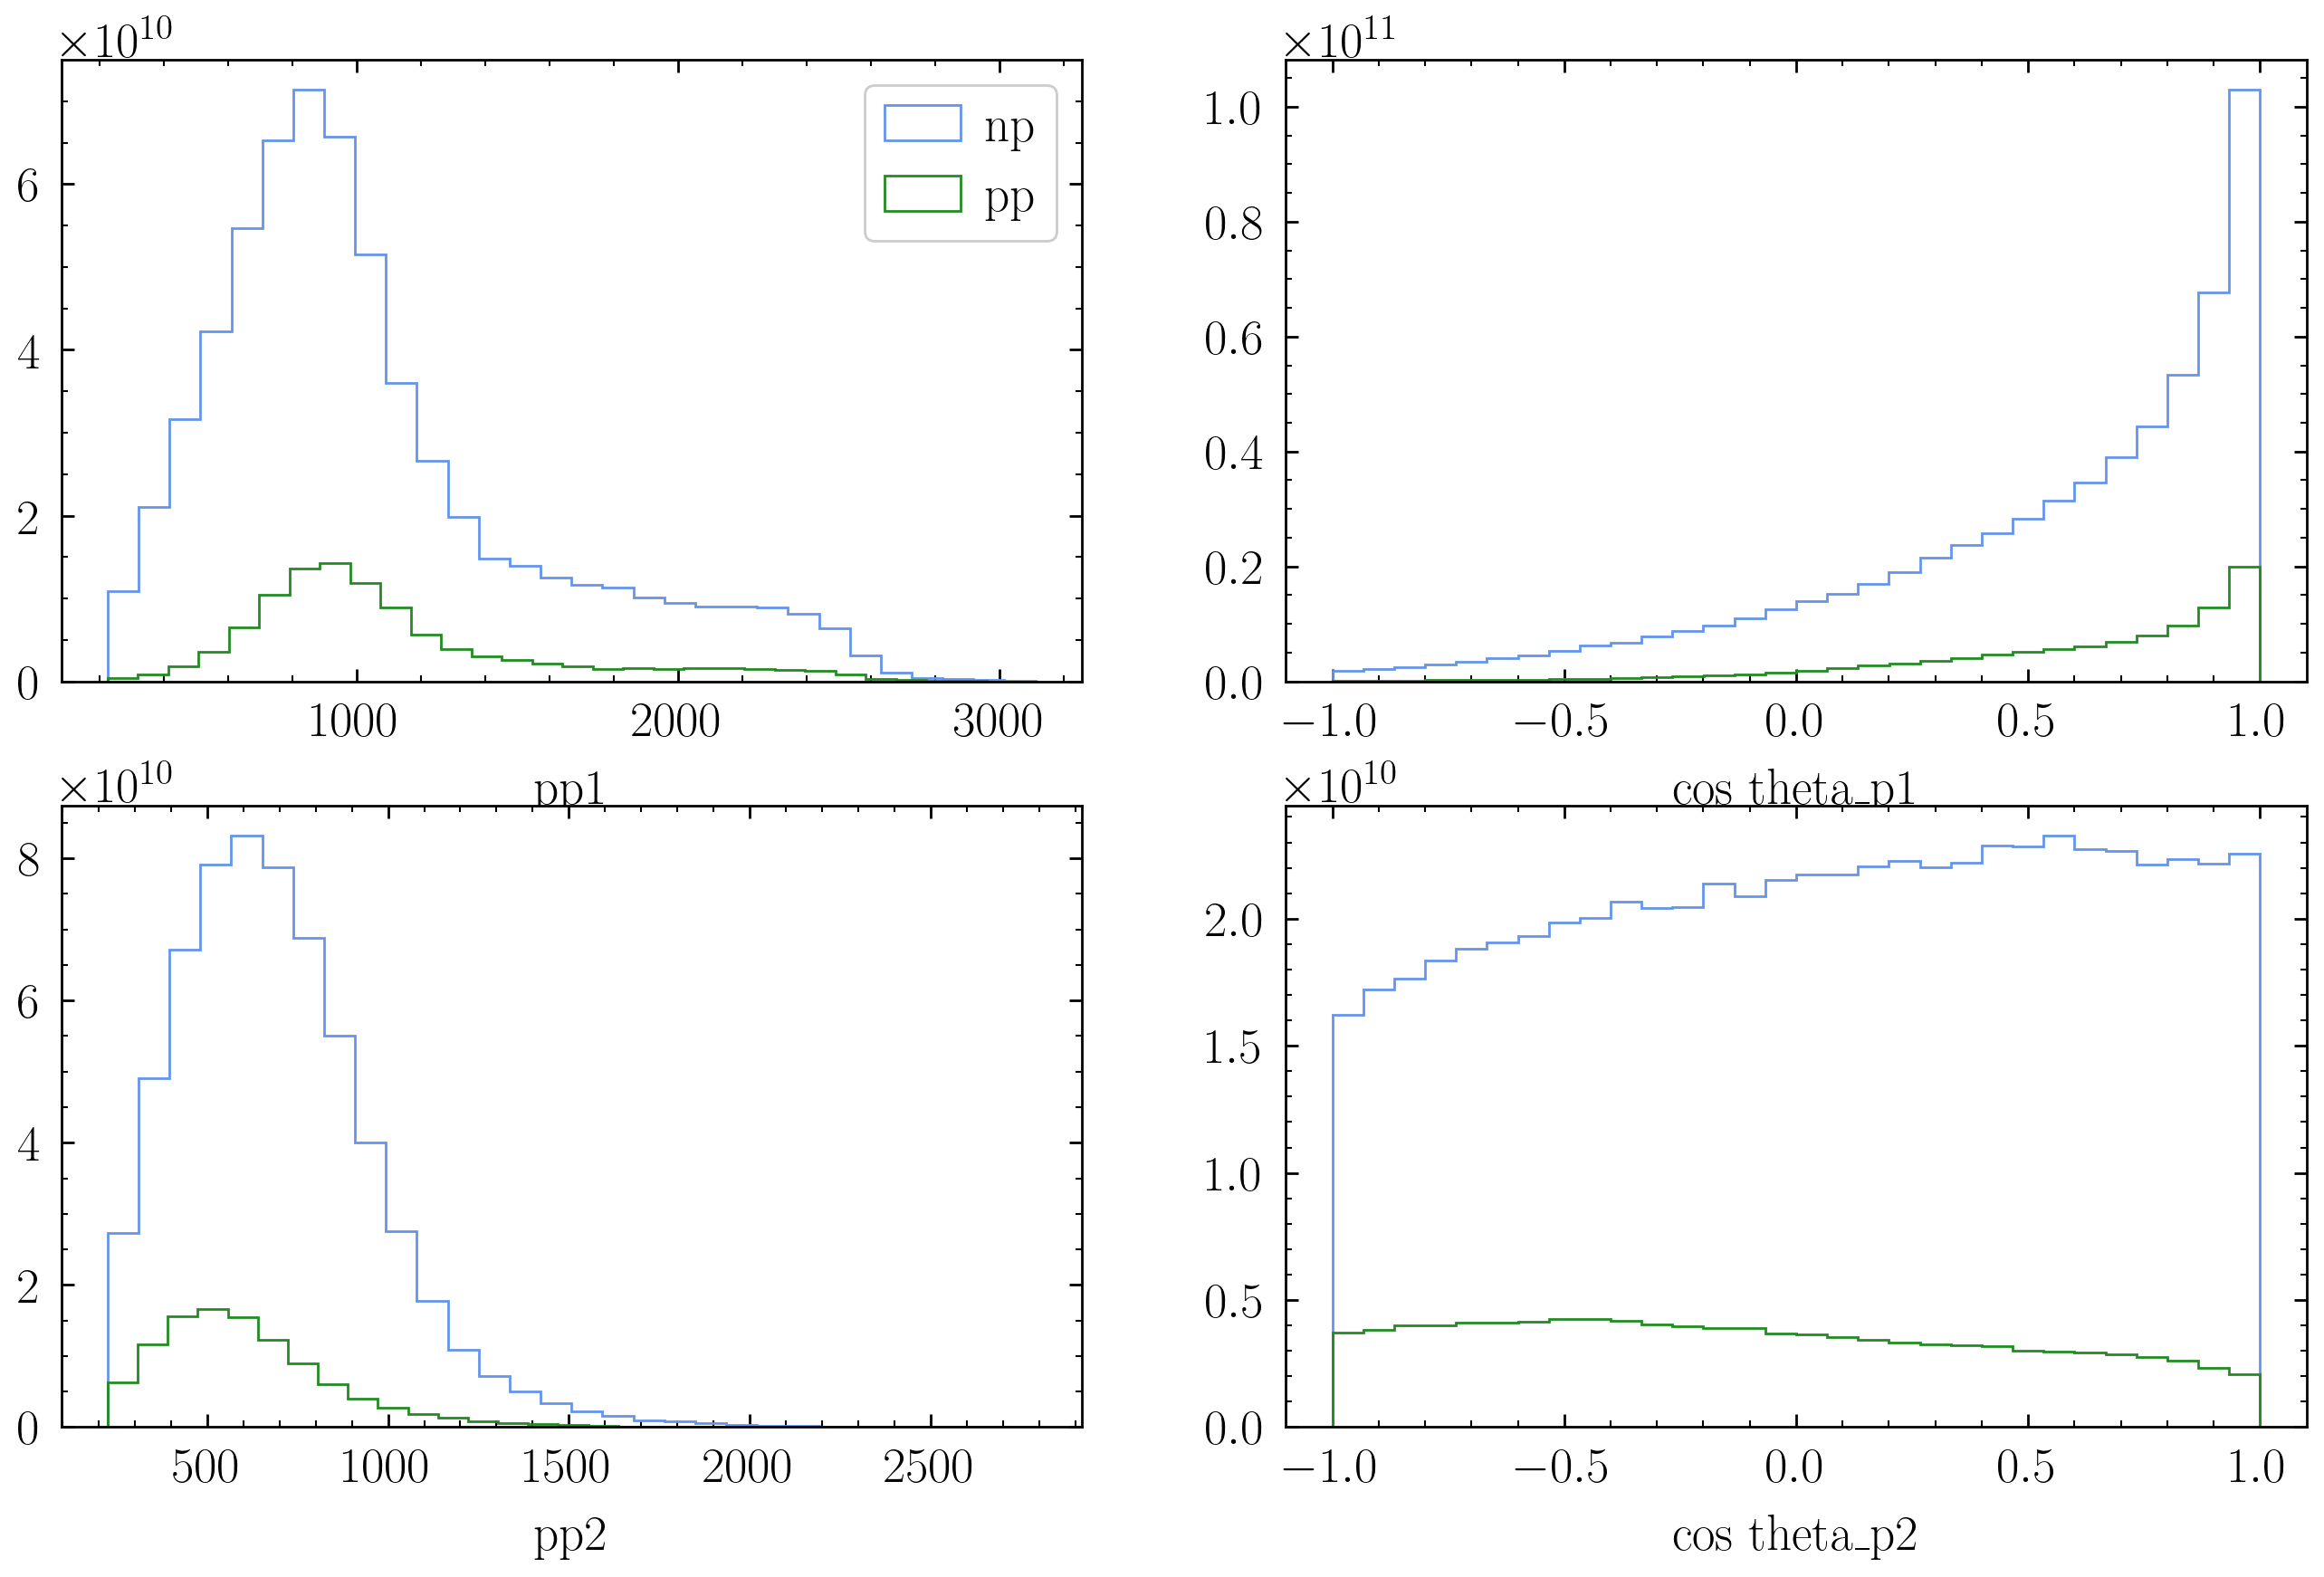

In [159]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

ax[0][0].hist(pp1_0,histtype='step',label='np',weights=np.ones_like(pp1_0)*noah_xsec0SF,bins=30)
ax[0][0].hist(pp1_1,histtype='step',label='pp',weights=np.ones_like(pp1_1)*noah_xsec1SF,bins=30)
ax[0][0].set_xlabel('pp1')


ax[1][0].hist(pp2_0,histtype='step',label='np',weights=np.ones_like(pp2_0)*noah_xsec0SF,bins=30)
ax[1][0].hist(pp2_1,histtype='step',label='pp',weights=np.ones_like(pp2_1)*noah_xsec1SF,bins=30)
ax[1][0].set_xlabel('pp2')

ax[0][1].hist(p1cos_0,histtype='step',label='np',weights=np.ones_like(pp12cos_0)*noah_xsec0SF,bins=30)
ax[0][1].hist(p1cos_1,histtype='step',label='pp',weights=np.ones_like(pp12cos_1)*noah_xsec1SF,bins=30)
ax[0][1].set_xlabel('cos theta_{p1}')


ax[1][1].hist(p2cos_0,histtype='step',label='np',weights=np.ones_like(p12cos_0)*noah_xsec0SF,bins=30)
ax[1][1].hist(p2cos_1,histtype='step',label='pp',weights=np.ones_like(p12cos_1)*noah_xsec1SF,bins=30)
ax[1][1].set_xlabel('cos theta_{p2}')
ax[0][0].legend()

(array([[152., 148., 166., ...,  49.,  39.,  35.],
        [163., 184., 171., ...,  55.,  40.,  38.],
        [182., 193., 226., ...,  49.,  42.,  30.],
        ...,
        [  3.,   6.,   3., ...,   0.,   0.,   0.],
        [  3.,   0.,   3., ...,   1.,   0.,   1.],
        [  0.,   0.,   1., ...,   1.,   0.,   0.]]),
 array([ 225.00654212,  249.41446716,  273.82239219,  298.23031723,
         322.63824226,  347.0461673 ,  371.45409234,  395.86201737,
         420.26994241,  444.67786744,  469.08579248,  493.49371751,
         517.90164255,  542.30956758,  566.71749262,  591.12541765,
         615.53334269,  639.94126772,  664.34919276,  688.75711779,
         713.16504283,  737.57296786,  761.9808929 ,  786.38881794,
         810.79674297,  835.20466801,  859.61259304,  884.02051808,
         908.42844311,  932.83636815,  957.24429318,  981.65221822,
        1006.06014325, 1030.46806829, 1054.87599332, 1079.28391836,
        1103.69184339, 1128.09976843, 1152.50769347, 1176.9156185 ,

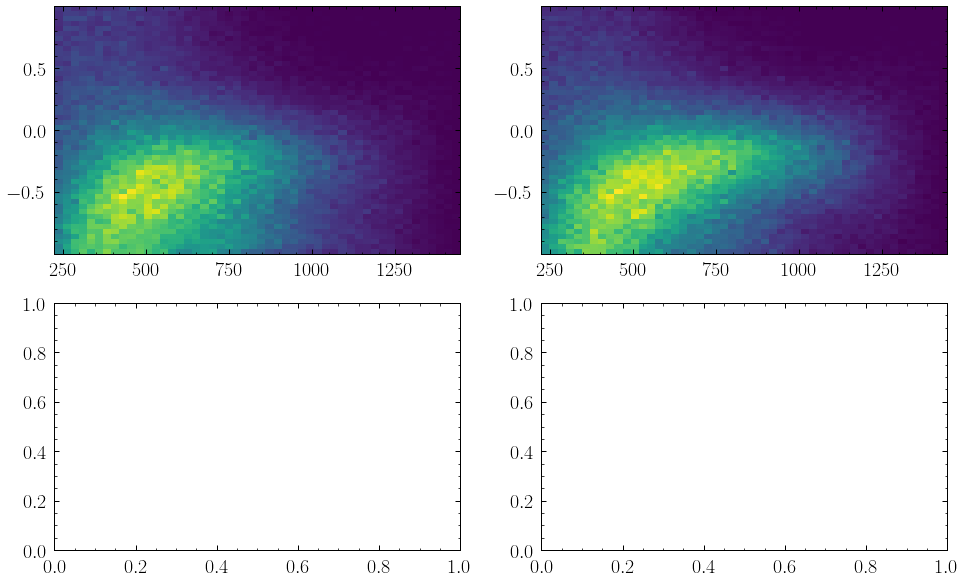

In [21]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

ax[0][0].hist2d(pp2_0,pp12cos_0,bins=50)
ax[0][1].hist2d(pp2_1,pp12cos_1,bins=50)

In [21]:
#Fixed omega
numbins = 30
omegalows = [100]
omegahighs = [900]

dtheta = 1
angles = [31.79]

#noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,pp1cos_1, pp2cos_1,noah_weights1SF = get_double_diff_xsec('test_1_FG_1000_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)


#noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,pp1cos_0, pp2cos_0,noah_weights0SF = get_double_diff_xsec('test_0_FG_1000_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)

noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,pp1cos_1, pp2cos_1,noah_weights1SF = get_double_diff_xsec('test_1_SF_1000_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)


noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,pp1cos_0, pp2cos_0,noah_weights0SF = get_double_diff_xsec('test_0_SF_1000_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)
 

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  2.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  1., ..., 37., 30.,  7.]]),
 array([   2.9599058 ,   23.32405766,   43.68820953,   64.0523614 ,
          84.41651327,  104.78066514,  125.14481701,  145.50896888,
         165.87312075,  186.23727262,  206.60142449,  226.96557636,
         247.32972823,  267.6938801 ,  288.05803197,  308.42218384,
         328.78633571,  349.15048758,  369.51463945,  389.87879132,
         410.24294319,  430.60709506,  450.97124693,  471.3353988 ,
         491.69955067,  512.06370254,  532.4278544 ,  552.79200627,
         573.15615814,  593.52031001,  613.88446188,  634.24861375,
         654.61276562,  674.97691749,  695.34106936,  715.70522123,
         736.0693731 ,  756.43352497,  776.79767684,  797.16182871,
         817.52598058,  837.8901324

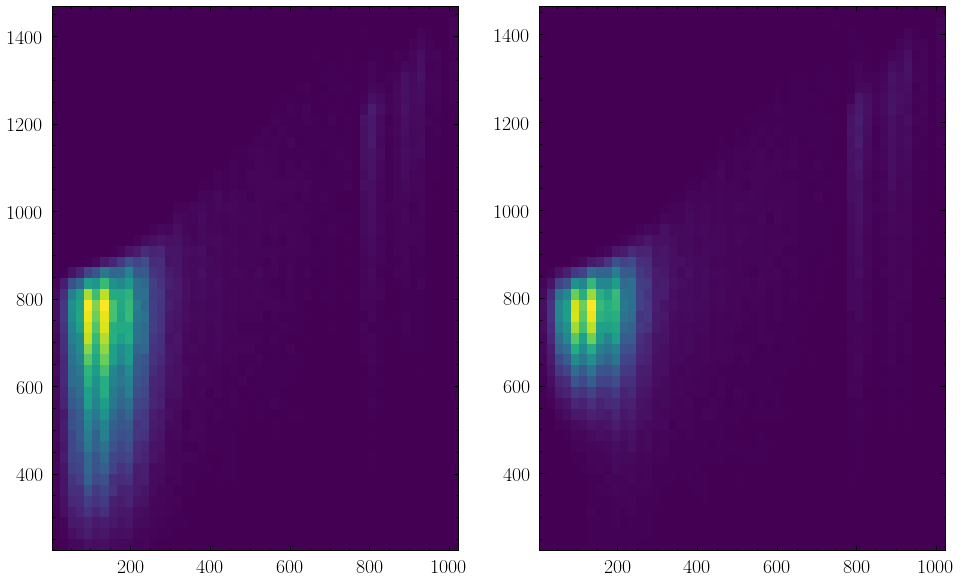

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,10))

ax[0].hist2d(p1_0,pp1_0,bins=50,label='np')
ax[1].hist2d(p1_1,pp1_1,bins=50,label='np')

(array([[ 0.,  0.,  0., ...,  8.,  4.,  0.],
        [ 0.,  0.,  0., ...,  6.,  6.,  5.],
        [ 0.,  0.,  0., ..., 13.,  6.,  0.],
        ...,
        [96., 83., 94., ...,  1.,  0.,  0.],
        [58., 52., 62., ...,  1.,  0.,  0.],
        [24., 12., 21., ...,  1.,  0.,  0.]]),
 array([225.12865843, 239.02244861, 252.9162388 , 266.81002898,
        280.70381916, 294.59760935, 308.49139953, 322.38518972,
        336.2789799 , 350.17277009, 364.06656027, 377.96035045,
        391.85414064, 405.74793082, 419.64172101, 433.53551119,
        447.42930138, 461.32309156, 475.21688174, 489.11067193,
        503.00446211, 516.8982523 , 530.79204248, 544.68583267,
        558.57962285, 572.47341303, 586.36720322, 600.2609934 ,
        614.15478359, 628.04857377, 641.94236395, 655.83615414,
        669.72994432, 683.62373451, 697.51752469, 711.41131488,
        725.30510506, 739.19889524, 753.09268543, 766.98647561,
        780.8802658 , 794.77405598, 808.66784617, 822.56163635,
        836

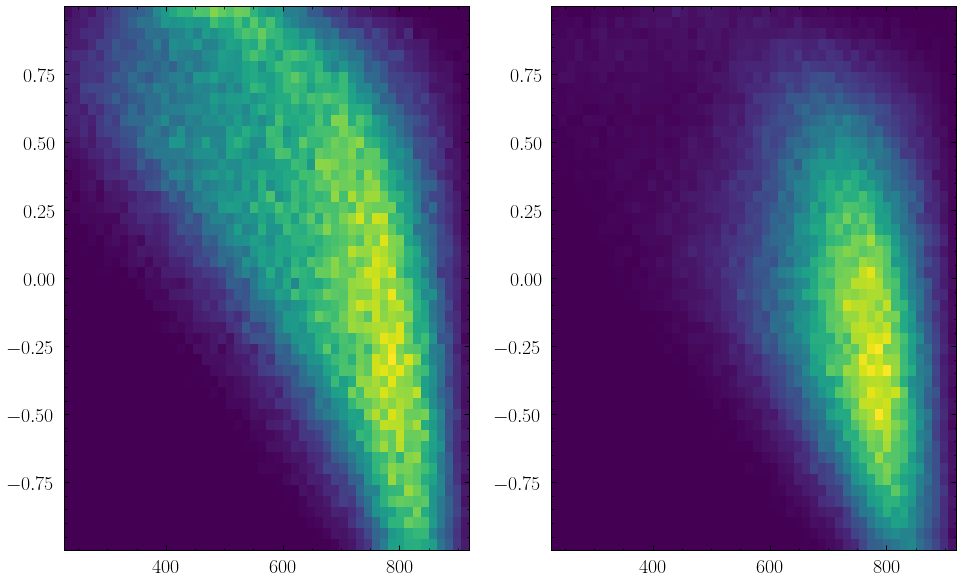

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,10))

ax[0].hist2d(pp1_0,pp2cos_0,bins=50,label='np')
ax[1].hist2d(pp1_1,pp2cos_1,bins=50,label='np')

In [62]:
p2cos_1

[0.9867935102729736,
 -0.678526346501059,
 0.2938979171244723,
 0.4266099542714816,
 0.8288005616744756,
 -0.120018064033664,
 -0.3008469413484558,
 -0.8462331781450737,
 -0.6943833967589044,
 -0.2509668449492713,
 -0.18012538867311317,
 -0.23842343021859017,
 0.6438649306078646,
 0.04304165833095601,
 0.6386971270054445,
 -0.19581686960854666,
 -0.6795853577282099,
 -0.952004426051182,
 -0.9558622762785369,
 -0.934009913259037,
 -0.23441182707294647,
 0.6658678372882212,
 -0.29057515361247677,
 0.31909083373140135,
 -0.015474535868753947,
 0.743051821026044,
 -0.24169867065020895,
 0.545219971642123,
 0.646837670106214,
 -0.5445559091812117,
 0.8098501105412106,
 0.9213924484157973,
 0.3270349687600369,
 -0.6885458051156729,
 0.752565534144191,
 -0.5748497984469795,
 -0.19275255951841155,
 -0.1677269035198422,
 -0.9737980630692848,
 0.14138069913310802,
 0.8528983827151065,
 -0.04884348583036899,
 -0.01729214343847846,
 -0.8016976277908044,
 0.15090546021713364,
 0.7336049333063941,
 

In [60]:
#Neutrinos

#Fixed omega
numbins = 30
omegalows = [100]
omegahighs = [900]

dtheta = 1
angles = [31.79]

noah_angular1SF,noah_dsig1SF,p1_1,p2_1,pp1_1,pp2_1,p12cos_1,pp12cos_1,p1cos_1,p2cos_1,pp1cos_1, pp2cos_1,noah_weights1SF = get_double_diff_xsec('../EW_MEC/test_1_FG_950_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)


noah_angular0SF,noah_dsig0SF,p1_0,p2_0,pp1_0,pp2_0,p12cos_0,pp12cos_0,p1cos_0,p2cos_0,pp1cos_0, pp2cos_0,noah_weights0SF = get_double_diff_xsec('../EW_MEC/test_0_FG_950_31p79_w350_contract.out', angles, dtheta, 173.77395066628236, noah_numevents, numbins, omegalows, omegahighs)

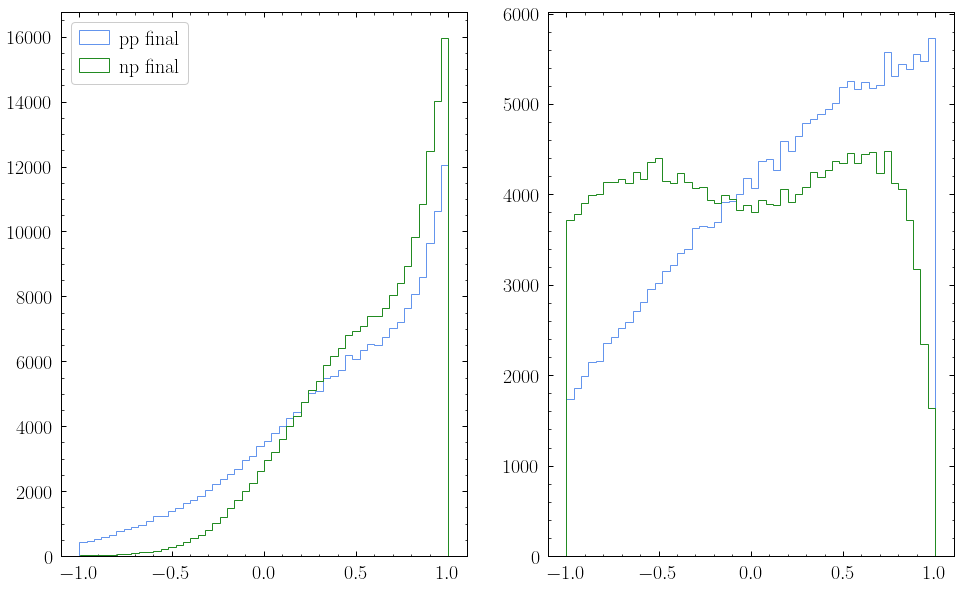

In [67]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].hist(pp1cos_0,bins=50,label='pp final',histtype='step')
ax[0].hist(pp1cos_1,bins=50,label='np final',histtype='step')
ax[1].hist(pp2cos_0,bins=50,label='pp final',histtype='step')
ax[1].hist(pp2cos_1,bins=50,label='np final',histtype='step')
ax[0].legend()

#ax[1].hist(pp2cos_0,bins=50,histtype='step',label='pp final')
#ax[1].hist(pp2cos_1,bins=50,histtype='step',label='np final')

(array([ 3656.,  4896.,  6178.,  7653.,  9192., 10497., 11667., 12378.,
        13211., 13498., 13521., 13099., 12751., 11558., 10589.,  9280.,
         7854.,  6710.,  5600.,  4499.,  3430.,  2570.,  1882.,  1197.,
          838.,   590.,   438.,   369.,   279.,    98.]),
 array([225.00451221, 246.19913107, 267.39374994, 288.5883688 ,
        309.78298766, 330.97760653, 352.17222539, 373.36684425,
        394.56146312, 415.75608198, 436.95070084, 458.14531971,
        479.33993857, 500.53455743, 521.7291763 , 542.92379516,
        564.11841402, 585.31303289, 606.50765175, 627.70227062,
        648.89688948, 670.09150834, 691.28612721, 712.48074607,
        733.67536493, 754.8699838 , 776.06460266, 797.25922152,
        818.45384039, 839.64845925, 860.84307811]),
 <BarContainer object of 30 artists>)

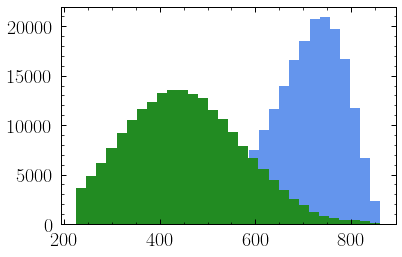

In [59]:
plt.hist(pp1_1,bins=30)
plt.hist(pp2_1,bins=30)